## Loading Libraries

In [2]:
library('ggplot2')
library('gridExtra')
require('randomForest')
library(repr)
library(ROCR)
library(LSD)
library(RColorBrewer)
library(grid)
library(reshape2)
library(ggsignif)
library(plyr)
library(scales)

## Plotting Functions

In [3]:
add_corner_label <- function(p, letter){
    newp <- arrangeGrob(p, top=textGrob(letter, x=unit(0, "npc"), y=unit(1, "npc"), just=c("left", "top")))
    return(newp)
}

make_into_stars<-function(x){
    s=""
    if (x <= 0.05){s="*"}
    if (x <= 0.01){s="**"}
    if (x <= 0.001){s="***"}
    if (x <= 0.0001){s="****"}
    return(s)
}

################################################
# For changing the labels of the ENCODE features, etc. 
# to make them pretty for the plots. 
fixlabels <- function(fnames){
	x=sub("wgEncode", "", fnames)
	x = sub("Nhek", "", x )
    x = sub("Helas3", "", x )
    x = sub("Mcf7", "", x)
    x = sub("K562", "", x)
    x= sub("Pol2Sig", "Pol2b", x)
	x= sub("Broad", "", x)
	x = sub("StdSig", "", x)
	x= sub("SignalRep1", "", x)
	x = sub("Sig", "", x)
	x = sub("Uw", "", x)
    x = sub("Ucd", "", x)
	x= sub("RawRep2", "", x)
	x = sub("StdRawRep1", "", x)
    x = sub("OpenChromChip", "", x)
	x = sub("RegTxnCaltechRnaSeqR2x75Il200Pooled.bw", "RNA-Seq", x)
    x = sub("RegTxnCaltechRnaSeqR2x75Il200Pooled", "RNA-Seq", x)
    x = sub("CaltechRnaSeqR2x75Il200Rep1V2", "RNA-Seq", x)
	x= sub("GSE63525_NHEK_HiCCUPS_looplist", "HiC Loops", x)
    x = sub("GSE63874_Na_PDS_12_both", "G-quadruplex", x)
    x= sub("GSE63525_NHEK_combined.eigens", "HiC Eigenvectors", x)
    x= sub("GSE63525__combined.eigens", "HiC Eigenvectors", x)
    x= sub("Histone", "", x)
    x= sub("Tfbs", "Tfbs ", x)
    x= sub("Sydh", "", x)
    x =sub("H3k09me3", "H3K9me3", x)
    x = sub("me3b", "me3", x)
    x= sub("H3k", "H3K", x)
    x=sub("H2az", "H2A.Z", x)
    x = sub(".bigwig", "", x)
    x= sub(".bigWig", "", x)
    x=sub("RepliSeqSum", "Replication Seq", x)
    x=sub("Ctcf", "CTCF", x)
    x=sub("Ezh239875", "EZH2", x)
    x=sub("hg19.cage_peak_phase1and2combined_coord.merge", "Cage Peaks", x)
    return(x)
}

In [4]:
my_scatter_plot <- function(x, y, myxlim=NULL, myylim=NULL, quantile=FALSE, myxlab="x values", myylab="y values"){
    df <- data.frame(x=x, y=y)
    if (quantile){
        myylim=quantile(df$y, c(0.01, .99))
        myxlim=quantile(df$x, c(0.01, .99))
    }
    p=cor.test(df$x, df$y)
    if (p$p.value == 0){
        mytext=paste(" Pearson's cor: ", round(p$estimate, digits=4), sep="")} #, "\n p-value < 2.2e-16", sep="")
    else {
        mytext=paste(" Pearson's cor: ", round(p$estimate, digits=4), sep="")} # "\n p-value: ", round(p$p.value, digits=4), sep="")}
    # ggMarginal is being weird with using scale_x_continuous, so need to filter the data with the x and y limits 
    myi = df$x<=myxlim[2] & df$x >= myxlim[1] & df$y <= myylim[2] & df$y >= myylim[1]
    p1 <- ggplot(df[myi,], aes(x,y)) + geom_point(size=.1, alpha=0.1) + 
        xlab(paste0(myxlab, "\n\n")) + ylab(paste0("\n\n", myylab)) +
        annotate("text", x=-Inf, y=Inf, label=mytext, vjust=1.1, hjust=0, size=3) + 
        theme(axis.text=element_text(size=8), text=element_text(size=9), 
              plot.title=element_text(size=1))
        #stat_density2d(aes(fill=..level..), geom="polygon")+ scale_fill_gradient(low="blue", high="orange")
    pf <- ggExtra::ggMarginal(p1, type="density", size=5, margin="both")
    return(pf)
}

my_scatter_densplot <- function(x, y, d, myxlim=NULL, myylim=NULL, quantile=FALSE, 
                                myxlab="x values", myylab="y values", mydlab="dens") {
    df <- data.frame(x=x, y=y, d_score=d)
    if (quantile){
        myylim=quantile(df$y, c(0.01, .99))
        myxlim=quantile(df$x, c(0.01, .99))
    }
    p=cor.test(df$x, df$y)
    if (p$p.value == 0){
        mytext=paste(" Pearson's cor: ", round(p$estimate, digits=4), sep="")} #, "\n p-value < 2.2e-16", sep="")
    else {
        mytext=paste(" Pearson's cor: ", round(p$estimate, digits=4), sep="")} # "\n p-value: ", round(p$p.value, digits=4), sep="")}
    myi = df$x<=myxlim[2] & df$x >= myxlim[1] & df$y <= myylim[2] & df$y >= myylim[1]

    p1 <- ggplot(df) + geom_point(aes(x=x, y=y, col=d_score), size=0.6, alpha=0.7) + 
        xlim(myxlim) + ylim(myylim) + scale_colour_gradient2() +
        labs(x=myxlab, y=myylab, colour=mydlab)
        #guides(fill=guide_legend(override.aes=list(size=3))) 
    #pf <- ggExtra::ggMarginal(p1, type="density", size=5, margin="both")
    return(p1)
}

## Set directories, inc working dir

In [5]:
setwd("../")
paperfigdir="../figures"
supfigdir="../figures/supfigures"

# MCF7 BLISS data
- I will take the combined data from RM118, RM119, RM121 (sum the DSB across these three datasets).  I will leave out the RM120 because this dataset looks noisier than the others (has a lower correlation value to each of the other three than the other three do to eachother) as shown in the graphs below. 

In [6]:
mdat <- read.table("MCF7_BICRO63/hg19_50kb_mcf7.txt", header=TRUE)
mdat[1,]

chr  start end   id RM118.bigWig RM119.bigWig RM120.bigWig RM121.bigWig
1 chr1 0     49999 1  0            4.00008e-05  2.00004e-05  2.00004e-05

In [16]:
p1 <- my_scatter_plot(x=mdat$RM118.bigWig, y=mdat$RM119.bigWig, quantile=TRUE, myxlab="RM118", myylab="RM119")
p2 <- my_scatter_plot(x=mdat$RM120.bigWig, y=mdat$RM119.bigWig, quantile=TRUE, myxlab="RM120", myylab="RM119")
p3 <- my_scatter_plot(x=mdat$RM121.bigWig, y=mdat$RM119.bigWig, quantile=TRUE, myxlab="RM121", myylab="RM119")

p4 <- my_scatter_plot(x=mdat$RM120.bigWig, y=mdat$RM118.bigWig, quantile=TRUE, myxlab="RM120", myylab="RM118")
p5 <- my_scatter_plot(x=mdat$RM121.bigWig, y=mdat$RM118.bigWig, quantile=TRUE, myxlab="RM121", myylab="RM118")
p6 <- my_scatter_plot(x=mdat$RM120.bigWig, y=mdat$RM121.bigWig, quantile=TRUE, myxlab="RM120", myylab="RM121")


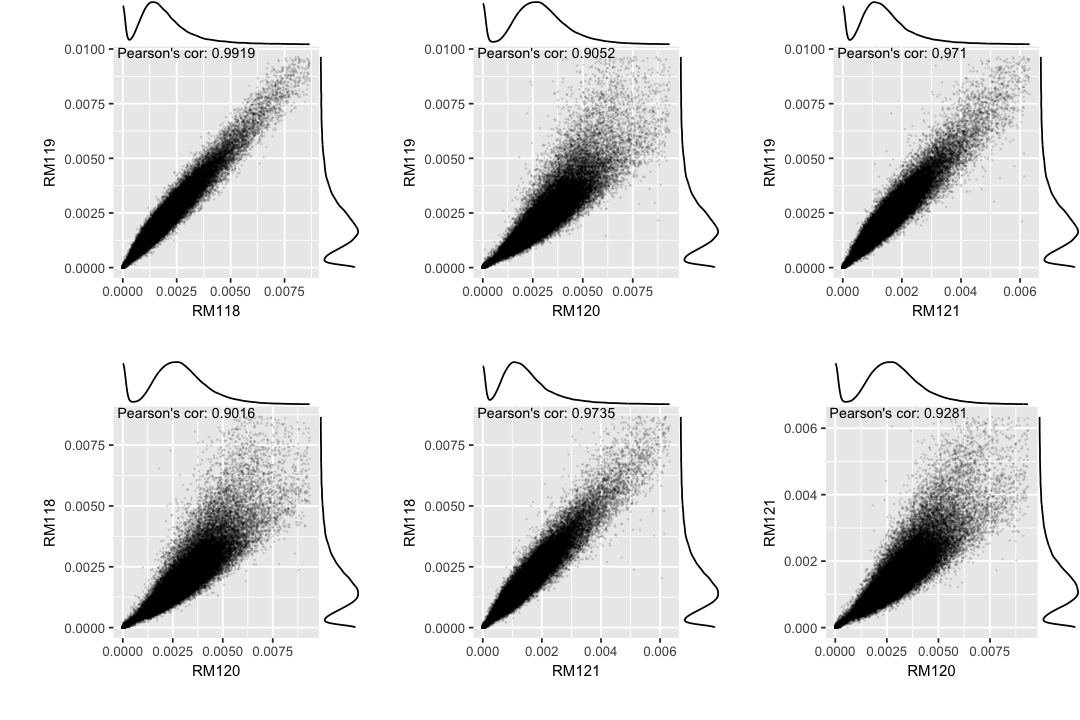

In [17]:
options(repr.plot.width=9, repr.plot.height=6)
grid.arrange(p1, p2, p3, p4, p5, p6, ncol=3)

# Figure 2 - scatter plots of models

### Plotting functions

In [6]:
################################################
# For Making a scatter plot of predicted versus 
# actual DSB frequencies. 
scatter_plot_predicted<- function(mydir, myylim, myxlim, quantile=FALSE){
    predresults <- read.table(paste(mydir, "predicted.txt", sep="/"), header=TRUE)
    breaklabels <- predresults$breaks
    df <- data.frame(x=predresults$breaks, y = predresults$predicted)
    if (quantile){
        myylim=quantile(df$y, c(0.01, .995))
        myxlim=quantile(df$x, c(0.01, .995))
    }
    p=cor.test(df$x, df$y)
    if (p$p.value == 0){
        mytext=paste(" Pearson's cor: ", round(p$estimate, digits=4), sep="")} #, "\n p-value < 2.2e-16", sep="")
    else {
        mytext=paste(" Pearson's cor: ", round(p$estimate, digits=4), sep="")} # "\n p-value: ", round(p$p.value, digits=4), sep="")}
    # ggMarginal is being weird with using scale_x_continuous, so need to filter the data with the x and y limits 
    myi = df$x<=myxlim[2] & df$x >= myxlim[1] & df$y <= myylim[2] & df$y >= myylim[1]
    p1 <- ggplot(df[myi,], aes(x,y)) + geom_point(size=.1, alpha=0.1) + 
        xlab("Observed DSB frequency\n\n") + ylab("\n\nPredicted DSB frequency") +
        annotate("text", x=-Inf, y=Inf, label=mytext, vjust=1.1, hjust=0, size=3) + 
        theme(axis.text=element_text(size=8), text=element_text(size=9), 
              plot.title=element_text(size=1))
        #stat_density2d(aes(fill=..level..), geom="polygon")+ scale_fill_gradient(low="blue", high="orange")
    pf <- ggExtra::ggMarginal(p1, type="density", size=5, margin="both")
    return(pf)
}

################################################
# For making a barplot of the important features in the 
# random forest models with errorbars.
# The input is a file that has the importance measure across several runs
# of the random forest (ie varimp.txt files)

barplot_imp_features_errbar <- function(dat, mytitle="", nfeatures=10){
    if (ncol(dat)==2){
        m=dat[,2];
        std=rep(0,ncol(dat))
    }
    else {
        m=apply(dat[,2:ncol(dat)], 1, mean, na.rm=TRUE)
        std=apply(dat[,2:ncol(dat)], 1, sd, na.rm=T)
    }
    datord <- order(m, decreasing=T)
    df <-data.frame(feature=fixlabels(dat[datord,1]), m=m[datord], std=std[datord])
    df$feature<- factor(df$feature, levels=unique(df$feature))

  p1 <- ggplot(data=df, aes(x=feature, y=m)) + 
    geom_bar(stat="identity", position=position_dodge(), fill="steelblue") + coord_flip() + 
    geom_errorbar(aes(ymin=m-std, ymax=m+std), width=.2, position=position_dodge(.9)) + 
    scale_x_discrete(limits=rev(levels(df$feature)[1:nfeatures])) + 
    ylab("Variable importance") +  
    theme_minimal() + 
    theme(plot.title = element_text(hjust=0.2, size=10), plot.margin=unit(c(-1,2,0,0), "lines"))
    return(p1)
}

## Figure2 : scatter plots of predicted vs observed and barcharts

In [128]:
#############################################################  
# MCF7 Data
mydir="MCF7_BICRO63/results_Mcf7_mNhek6/RM181921"
ps_mcf <- scatter_plot_predicted(mydir, quantile=FALSE, myxlim=c(0,0.035), myylim=c(0,0.035))
bardat=read.table(paste0(mydir, "/../RM181921.varimp.txt"), header=FALSE)
pb_mcf <- barplot_imp_features_errbar(bardat, nfeatures=11) + ggtitle("MCF7 BLISS")

In [129]:
#############################################################  
# NHEK DSBCapture data.
mydir="DSBCapture/results_Nhek6/GSM20687556_BREAK"
ps_nhek1 <- scatter_plot_predicted(mydir, quantile=FALSE, myylim=c(0,7), myxlim=c(0,7))
bardat=read.table(paste0(mydir, "/../GSM20687556_BREAK.varimp.txt"), header=FALSE)
pb_nhek1 <- barplot_imp_features_errbar(bardat, nfeatures=11) + ggtitle("NHEK DSBCapture")

In [130]:
mydir="DSBCapture/results_Nhek6/GSM20687578_BLESS"
ps_nhek2 <- scatter_plot_predicted(mydir, quantile=FALSE, myylim=c(0,2.5), myxlim=c(0,2.5))
bardat=read.table(paste0(mydir, "/../GSM20687578_BLESS.varimp.txt"), header=FALSE)
pb_nhek2 <- barplot_imp_features_errbar(bardat, nfeatures=11) + ggtitle("NHEK BLESS")

In [131]:
#############################################################  
# K562 BLISS data. 
mydir="BLISS/results_K562_mNhek6/rm106_CATCACGC_q30_chr-loc-countDifferentUMI"
ps_k562 <- scatter_plot_predicted(mydir, quantile=FALSE, myylim=c(0,0.002), myxlim=c(0,0.002))
bardat <- read.table(paste0(mydir, "/../rm106_CATCACGC_q30_chr-loc-countDifferentUMI.varimp.txt"), header=FALSE)
pb_k562 <- barplot_imp_features_errbar(bardat, nfeatures=11) + ggtitle("K562 BLISS")

In [132]:
## putting all plots together 
mygrobs=list(ps_nhek1, ps_nhek2, ps_k562, ps_mcf, pb_nhek1, pb_nhek2, pb_k562, pb_mcf)
length(mygrobs)

for (i in seq_along(mygrobs)){
    mygrobs[[i]] <- add_corner_label(mygrobs[[i]], letters[i])
}

[1] 8

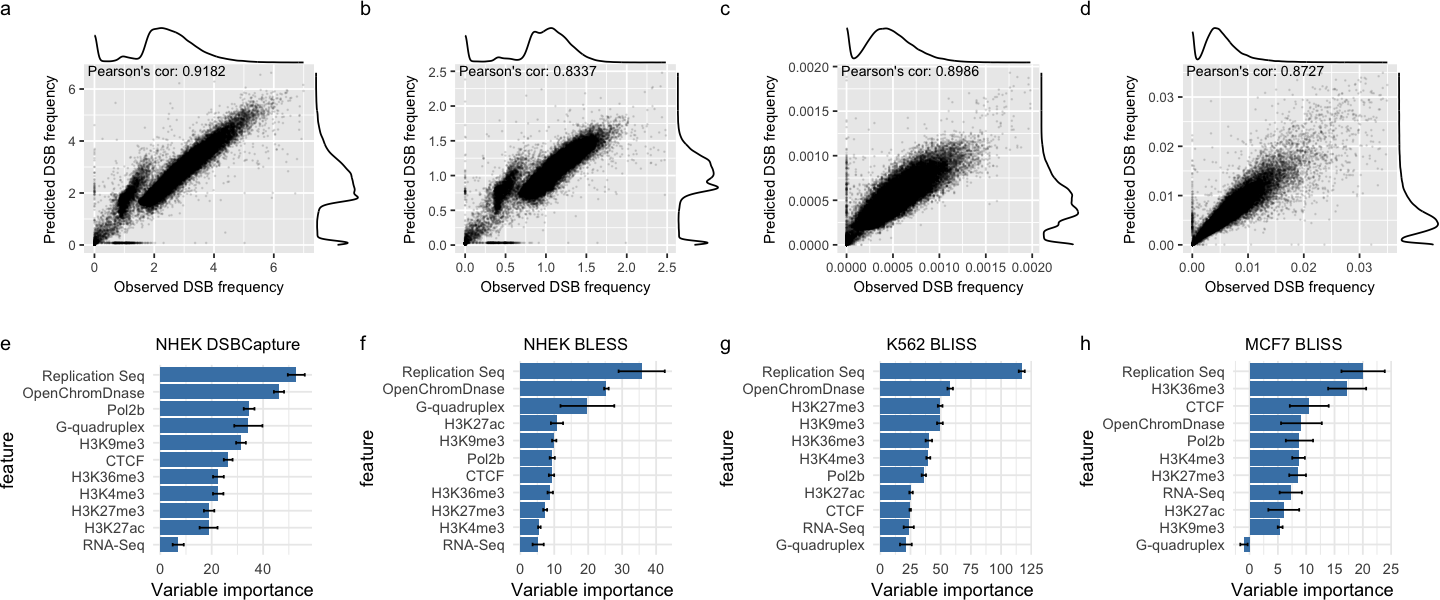

In [133]:
options(repr.plot.width=12, repr.plot.height=5)
g <- grid.arrange(grobs=mygrobs, ncol=4, heights=c(3.8,3))

In [134]:
ggsave(file="Figure2.pdf", plot=g, path=paperfigdir, width=12, height=5, units="in")
ggsave(file="Figure2.png", plot=g, path=paperfigdir, width=12, height=5, units="in", dpi=600)

## Scatter plot of predicting SV breakpoints

In [13]:
#############################################################  
# MCF7 Data
mydir="MCF7_BICRO63/results_icgc_brca"
ps_mcf <- scatter_plot_predicted(mydir, quantile=TRUE)
bardat=read.table(paste0(mydir, "/variable_importance.txt"), header=FALSE)
pb_mcf <- barplot_imp_features_errbar(bardat, nfeatures=11) + ggtitle("ICGC_BRCA")

Warning message:
“Removed 9 rows containing missing values (geom_errorbar).”

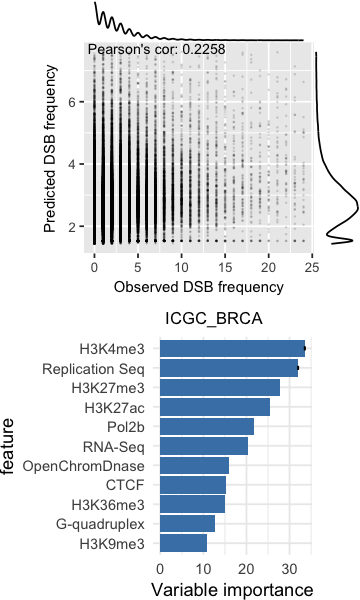

In [15]:
options(repr.plot.width=3, repr.plot.height=5)
g <- grid.arrange(ps_mcf, pb_mcf, nrow=2, heights=c(3.8,3))
ggsave(file="icgc_brca_rf.png", plot=g, path=supfigdir, width=3, height=5, units="in", dpi=300)

Below is adding in the cage data to the model (transcription)

In [10]:
#############################################################  
# MCF7 Data
mydir="MCF7_BICRO63/results_mNhek6_wcage"
ps_mcf <- scatter_plot_predicted(mydir, quantile=TRUE)
bardat=read.table(paste0(mydir, "/variable_importance.txt"), header=FALSE)
pb_mcf <- barplot_imp_features_errbar(bardat, nfeatures=11) + ggtitle("ICGC_BRCA")

Warning message:
“Removed 1 rows containing missing values (geom_bar).”Warning message:
“Removed 10 rows containing missing values (geom_errorbar).”

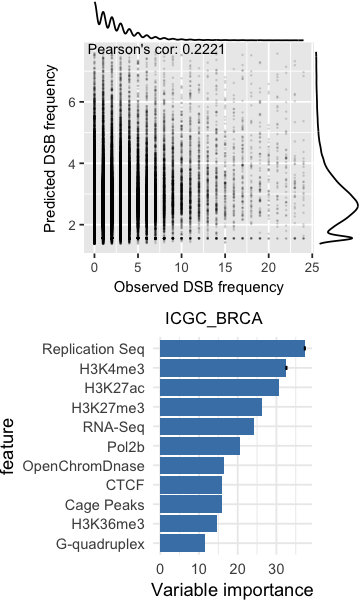

In [11]:
options(repr.plot.width=3, repr.plot.height=5)
g <- grid.arrange(ps_mcf, pb_mcf, nrow=2, heights=c(3.8,3))
ggsave(file="icgc_brca_rfwcage.png", plot=g, path=supfigdir, width=3, height=5, units="in", dpi=300)

### Aphicidolin model

In [9]:
#############################################################  
# MCF7 Data
mydir="breakome/results_w_nhekfeatures/aphidicolin"
ps_mcf <- scatter_plot_predicted(mydir, quantile=TRUE)
bardat=read.table(paste0(mydir, "/variable_importance.txt"), header=FALSE)
pb_mcf <- barplot_imp_features_errbar(bardat, nfeatures=11) + ggtitle("Aphidicolin induced breaks")

Warning message:
“Removed 15 rows containing missing values (geom_bar).”Warning message:
“Removed 25 rows containing missing values (geom_errorbar).”

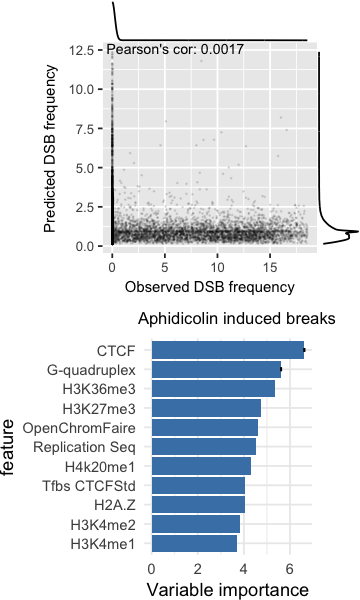

In [11]:
options(repr.plot.width=3, repr.plot.height=5)
g <- grid.arrange(ps_mcf, pb_mcf, nrow=2, heights=c(3.8,3))
ggsave(file="aphidicolin_model.png", plot=g, path=supfigdir, width=3, height=5, units="in", dpi=300)

## Heatmap of correlation between features

In [125]:
library('gplots')
feat=read.table("feature_sets/NHEK_features6.tab", header=TRUE)
dat=feat[,5:ncol(feat)]
cmat <- cor(dat, use="pairwise.complete.obs", method="spearman")
row.names(cmat) <- fixlabels(row.names(cmat))

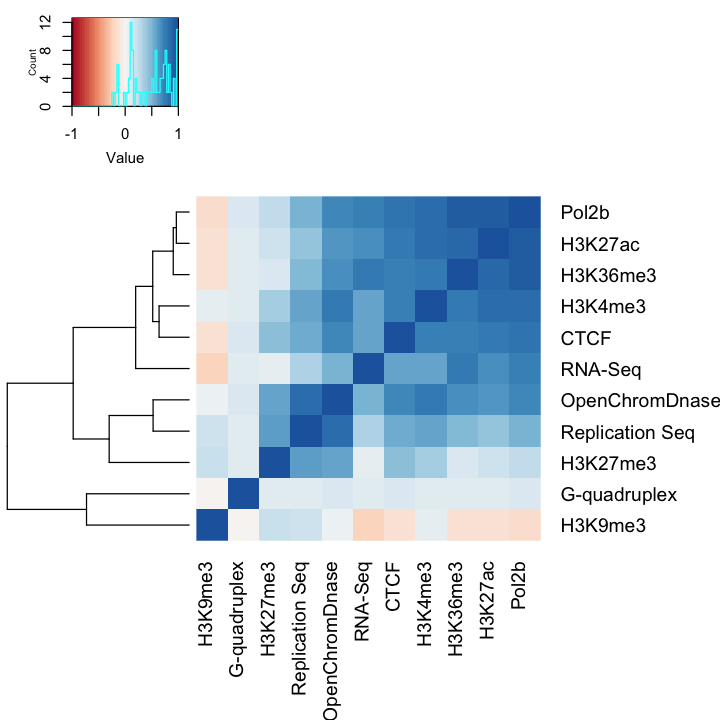

In [127]:
options(repr.plot.width=6, repr.plot.height=6)
#png(paste(supfigdir, "dendro.png", sep="/"), width=10, height=8)
heatmap.2(cmat, trace="none", dendrogram='row', 
          labCol=fixlabels(labels(cmat)[[2]]), margins=c(9,9), 
          col=colorRampPalette(brewer.pal(9, "RdBu"))(64), key.title=NA)

#dev.off()

# Figure3- Cross application of models

## Data processing... 

In [135]:
compare_cross_models<- function(mymodel, myfeatures, mytrue){
    load(mymodel)
    nnames=labels(all.mod$importance)[[1]]
    nfix <- fixlabels(nnames)
    kfeat <- read.table(myfeatures, header=TRUE)
    kfeat <- kfeat[,5:ncol(kfeat)]
    knames=fixlabels(names(kfeat))
    newnames = nnames[pmatch(knames,nfix)]
    names(kfeat) <- newnames
    pnew <- predict(all.mod, newdata=kfeat)
    #pnew[is.na(pnew)]=0
    ktrue <- read.table(mytrue, header=TRUE)
    ktrue <- ktrue[,5]
    pnk1 <- cor.test(pnew, ktrue)
    return(pnk1)
}

In [136]:
modelN="DSBCapture/results_Nhek6/GSM20687556_BREAK/all.mod.rdf"
modelK="BLISS/results_K562_mNhek6/rm106_CATCACGC_q30_chr-loc-countDifferentUMI/all.mod.rdf"
modelM="MCF7_BICRO63/results_Mcf7_mNhek6/RM181921/all.mod.rdf"
featuresN="feature_sets/NHEK_features6.tab"
featuresK="feature_sets/K562_mNhek_features6.tab"
featuresM="feature_sets/Mcf7_mNhek_features6.tab"
trueN="DSBCapture/GSM20687556_BREAK.scores.txt"
trueK="BLISS/hg19_50kb_k562_scores.txt.gz"
trueM="MCF7_BICRO63/RM181921_hg19_50kb_scores.bed"

In [137]:
#####################################################
# Get correlations for predictions and actual values
# under various models. 
pn_n <- compare_cross_models(modelN, featuresN, trueN)

In [138]:
pn_k <- compare_cross_models(modelN, featuresK, trueK)

In [139]:
pn_m <- compare_cross_models(modelN, featuresM, trueM)

In [140]:
pk_k <- compare_cross_models(modelK, featuresK, trueK)
pk_n <- compare_cross_models(modelK, featuresN, trueN)
pk_m <- compare_cross_models(modelK, featuresM, trueM)

In [141]:
pm_m <- compare_cross_models(modelM, featuresM, trueM)
pm_n <- compare_cross_models(modelM, featuresN, trueN)
pm_k <- compare_cross_models(modelM, featuresK, trueK)

In [142]:
ktrue <- read.table(trueK, header=TRUE)[,5]
ntrue <- read.table(trueN, header=TRUE)[,5]
mtrue <- read.table(trueM, header=TRUE)[,5]
cnk <- cor(ntrue, ktrue)
cnm <- cor(ntrue, mtrue)
ckm <- cor(ktrue, mtrue)

## Figure3b: Pearson's correlations for mixed models

In [143]:
### plot the correlation between the NHEK DSBCapture data and the predictions from various models. 
mycors=c()
for (p in list(pn_n, pn_k, pn_m, pk_n, pk_k, pk_m, pm_n, pm_k, pm_m)){
    mycors=c(mycors, p$estimate[[1]])
}
my_nomod <- c(1, cnk, cnm, cnk, 1, ckm, cnm, ckm, 1)
traindat <- factor(c("NHEK", "NHEK", "NHEK", "K562", "K562", "K562", "MCF7", "MCF7", "MCF7"),
                levels=c("NHEK", "K562", "MCF7"))
testingdat <- factor(c("NHEK", "K562", "MCF7", "NHEK", "K562", "MCF7", "NHEK", "K562", "MCF7"), 
                     levels=c("NHEK", "K562", "MCF7"))
df <- data.frame(y=mycors, x=testingdat, traindat=traindat, nomod=my_nomod)

myc1=brewer.pal(4, "Set2")[c(1,2,3)]
g <- ggplot(df, aes(x,y, fill=traindat)) + 
    geom_bar(stat="identity",  position=position_dodge(width=0.9)) +
    scale_fill_manual(values=myc1) + 
    labs(y="Pearson's correlation", x="input cell type", fill="model cell type") + 
    theme(axis.text.x=element_text(colour=myc1, size=10))

In [144]:
# add the marks for where the correlation is between datasets 
g2 <- g + geom_text(aes(label="---", y=nomod, group=traindat), colour="yellow", position=position_dodge(width=0.9))

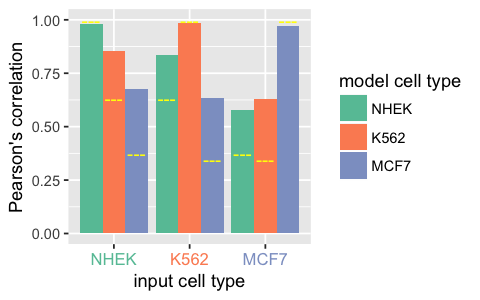

In [146]:
options(repr.plot.width=4, repr.plot.height=2.5)
g2
ggsave(file="Figure3.pdf", plot=g2, path=paperfigdir, width=5, height=3, units="in")
ggsave(file="Figure3.png", plot=g2, path=paperfigdir, width=5, height=3, units="in")

In [106]:
df

y         x    traindat nomod    
1 0.9781873 NHEK NHEK     1.0000000
2 0.8336424 K562 NHEK     0.6348716
3 0.5790091 MCF7 NHEK     0.3791670
4 0.8527749 NHEK K562     0.6348716
5 0.9836567 K562 K562     1.0000000
6 0.6299122 MCF7 K562     0.3508769
7 0.6764870 NHEK MCF7     0.3791670
8 0.6322238 K562 MCF7     0.3508769
9 0.9720129 MCF7 MCF7     1.0000000

## MCF7 predicted DSB calculation

In [ ]:
modelN="DSBCapture/results_Nhek6/GSM20687556_BREAK/all.mod.rdf"
myfeatures = "feature_sets/Mcf7_mNhek_features6.tab"
load(modelN)
kfeat <- read.table(myfeatures, header=TRUE)
kfeat <- kfeat[,5:ncol(kfeat)]
knames = fixlabels(names(kfeat))
nnames = labels(all.mod$importance)[[1]]
nfix <- fixlabels(nnames)
newnames = nnames[pmatch(knames,nfix)]
names(kfeat) <- newnames
predicted <- predict(all.mod, newdata=kfeat)
kfeat <- read.table(myfeatures, header=TRUE)
outdat <- cbind(kfeat[,1:4], predicted)
write.table(outdat, "DSBCapture/results_Nhek6/GSM20687556_BREAK.Mcf7/predicted.txt", quote=FALSE, row.names=FALSE, sep="\t")

# Heatmap of model
### Plotting functions 

In [8]:
################################################
# For Making a scatter plot of predicted versus 
# actual DSB frequencies. 
scatter_plot_predicted_p1<- function(mydir, myylim, myxlim, quantile=FALSE){
    predresults <- read.table(paste(mydir, "predicted.txt", sep="/"), header=TRUE)
    breaklabels <- predresults$breaks
    df <- data.frame(x=predresults$breaks, y = predresults$predicted)
    if (quantile){
        myylim=quantile(df$y, c(0.01, .99))
        myxlim=quantile(df$x, c(0.01, .99))
    }
    p=cor.test(df$x, df$y)
    if (p$p.value ==0){
        mytext=paste(" Pearson's cor: ", round(p$estimate, digits=4), sep="")  
                     #"\n p-value < 2.2e-16", sep="")
    }
    else {
    mytext=paste(" Pearson's cor: ", round(p$estimate, digits=4), sep="") 
       # "\n p-value: ", round(p$p.value, digits=4), sep="")
    }
    myi = df$x<=myxlim[2] & df$x >= myxlim[1] & df$y <= myylim[2] & df$y >= myylim[1]
    p1 <- ggplot(df[myi,], aes(x,y)) + geom_point(size=.1, alpha=0.1) + 
        xlab("Observed DSB frequency\n\n") + ylab("\n\nPredicted DSB frequency") +
        annotate("text", x=-Inf, y=Inf, label=mytext, vjust=1.1, hjust=0, size=3) + 
        theme(axis.text=element_text(size=9), text=element_text(size=11), plot.title=element_text(size=1))
    return(p1)
}

In [9]:
#### Making a heatmap of the features 
make_heat_map <- function(dat, mytitle="", featlabs=NULL, legend=TRUE, ylabs=TRUE){
    datm <- melt(dat, id.vars="id")
    datm$variable <- factor(datm$variable, levels=featlabs)
    mylabels=fixlabels(rev(featlabs))
    mylabels=sub("breaks", "Observed DSB", mylabels)
    mylabels=sub("predicted", "Predicted DSB", mylabels)
    mylabels=sub("mapability", "Mapability", mylabels)
    datm$value[datm$value>1]=1.1
    p1 <- ggplot(datm, aes(x=id, y=variable)) + 
        geom_tile(aes(fill=value)) + scale_fill_gradient(limits=c(0,1.1)) + 
        theme(axis.text.x=element_blank(), axis.ticks.x=element_blank()) + 
        theme(plot.margin=unit(c(-1,0,1,0),"lines")) + 
        scale_y_discrete(limit=rev(featlabs), labels=mylabels) + 
        labs(x="", subtitle=mytitle, fill="value")
    if (legend == FALSE){ 
        p1 = p1 + guides(fill=FALSE) + theme(plot.margin=unit(c(-1, 0, 1, 0), "lines"))
    }
    if (ylabs){
        p1 = p1 + theme(axis.text.y=element_text(size=8), plot.margin=unit(c(-1,0,1,1), "lines")) + 
        labs(y="Features")
    }
    if (!ylabs){
        p1 = p1 + theme(axis.ticks.y=element_blank(), axis.text.y = element_blank(), 
                        plot.margin=unit(c(-1,0,1,-.5), "lines")) + 
        labs(y="")
    }
    return(p1)
}

## NHEK model reduced to match MCF7

In [10]:
###  Read in the data and rescale it. 
mydir="DSBCapture/results_Nhek6/GSM20687556_BREAK"
dat <- read.table("feature_sets/NHEK_features6.tab", header=TRUE)
pdat <- read.table(paste(mydir, "predicted.txt", sep="/"), header=TRUE)
dat=dat[,4:ncol(dat)]
dat$predicted=pdat$predicted
dat$breaks=pdat$breaks
## add in mapability 
mapdat<- read.table("feature_sets/hg19_50kb_MapabilityAlign100mer.scores", header=TRUE)
dat$mapability<-mapdat$wgEncodeCrgMapabilityAlign100mer

dat$id <- with(dat, reorder(id, predicted))
for (i in seq(2, ncol(dat))){
    dat[,i]=rescale(dat[,i], to=c(0,1), from=quantile(dat[,i], c(.01, .99), na.rm=TRUE))
}
impd <- read.table(paste(mydir, "variable_importance.txt", sep="/"), header=FALSE)
myfeat=c("breaks", "predicted", as.character(impd$V1), "mapability")

In [11]:
## Get indices of sampled points for the range of predicted values. 
bins = seq(1.7,5, by=0.002)
xi=rep(0, (length(bins)-1))

for (i in c(1:(length(bins)-1))){
	xmin=bins[i]
	xmax=bins[i+1]
	indx=which(pdat$predicted >=xmin & pdat$predicted <xmax & pdat$breaks >= xmin-0.1 & pdat$breaks < xmax + 0.1)
	if (length(indx)==1){xi[i] = indx[1]}
    if (length(indx)>1){
		xi[i] = sample(indx, 1)
	}
}

xi=xi[xi!=0]
xisamp <- xi

## Set boundaries of boxes
limsA=c(.1, .6, .1, .9)
limsB=c(0.7, 1.5, 1.5, 2.7)
limsC=c(0.6, 1.8, 0, .2)


### Figure4a: scatter plot with highlighted regions

In [12]:
p <- scatter_plot_predicted_p1(mydir, myylim=c(0,6), myxlim=c(0,6))

lims=limsA
p <- p + annotate("rect", xmin=lims[1], xmax=lims[2], ymin=lims[3], ymax=lims[4], alpha=.2, colour="steelblue") + 
        annotate("text", x=lims[1], y=lims[4], label="A", colour="steelblue", hjust=-0.1, vjust=1.1, size=4)
lims=limsB
p <- p + annotate("rect", xmin=lims[1], xmax=lims[2], ymin=lims[3], ymax=lims[4], alpha=.2, colour="steelblue") + 
        annotate("text", x=lims[1], y=lims[4], label="B", colour="steelblue", hjust=-0.1, vjust=1.1, size=4)

subsamp <- pdat[xi,]
p <- p + geom_point(data=subsamp, aes(x=subsamp$breaks, y=subsamp$predicted), colour="steelblue", size=.2) + 
    annotate("text", x=2, y=4, label="C", colour="steelblue") + 
    annotate("segment", x=2, y=3.8, xend=2.5, yend=2.5, colour="steelblue")

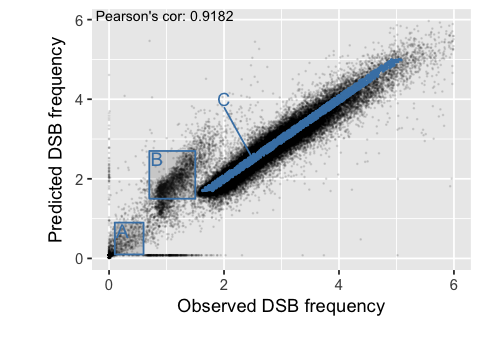

In [13]:
options(repr.plot.width=4, repr.plot.height=3)
pscat <- p
p
#ggsave(file="Figure4a.pdf", plot=pscat, path=paperfigdir, width=4, height=4, units="in")

### Figure4

In [14]:
mydat <- dat[xisamp,]
mytitle=paste("Group C: 1.7-5\n", "(", length(xisamp), ")", sep="")
prange <- make_heat_map(dat=mydat, featlabs=myfeat, mytitle=mytitle, ylabs=TRUE)

### Plots for Boxed regions
lims=limsA
xi <- pdat$breaks > lims[1] & pdat$breaks < lims[2] & pdat$predicted > lims[3] & pdat$predicted < lims[4]
mydat <- dat[xi,]
mytitle=paste("Box A: ", lims[1], "-", lims[2], "\n", "(", sum(xi), ")", sep="")
pboxA <- make_heat_map(dat=mydat, featlabs=myfeat, mytitle=mytitle, legend=FALSE, ylabs=TRUE)

lims=limsB
xi <- pdat$breaks > lims[1] & pdat$breaks < lims[2] & pdat$predicted > lims[3] & pdat$predicted < lims[4]
mydat <- dat[xi,]
mytitle=paste("Box B: ", lims[1], "-", lims[2], "\n", "(", sum(xi), ")", sep="")
pboxB <- make_heat_map(dat=mydat, featlabs=myfeat, mytitle=mytitle, legend=TRUE, ylabs=FALSE)

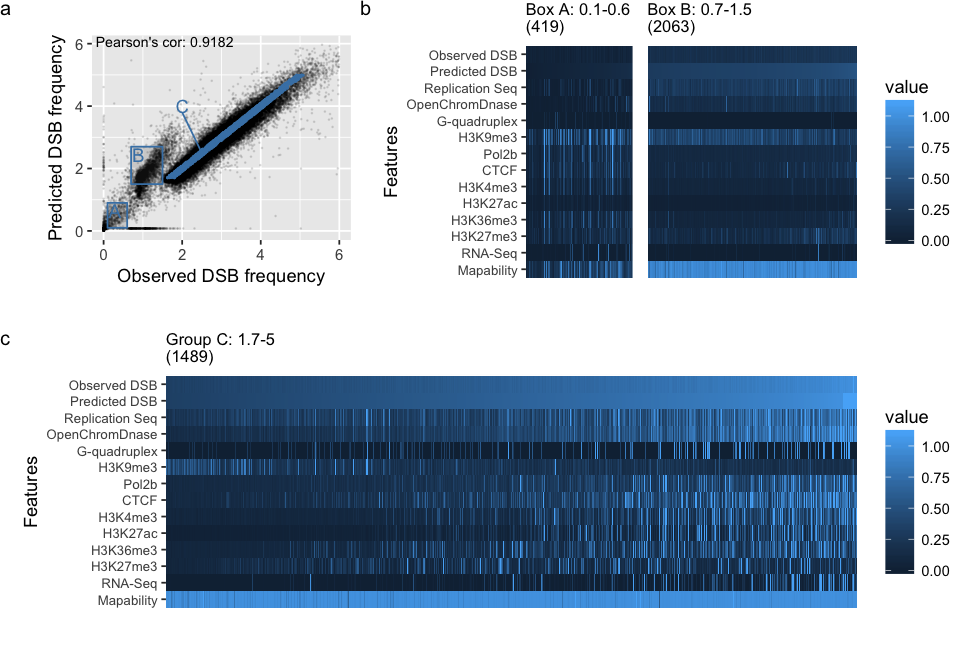

In [15]:
ps <- add_corner_label(pscat, "a")
gAB <- arrangeGrob(grobs=c(list(pboxA), list(pboxB)), ncol=2, widths=c(2.5,3))
gAB <- add_corner_label(gAB, "b")
gtop <- arrangeGrob(grobs=c(list(ps), list(gAB)), ncol=2, widths=c(3,5))
gbot <- arrangeGrob(grobs=c(list(prange)))
gbot <- add_corner_label(gbot, "c")
options(repr.plot.width=8, repr.plot.height=5.5)
g4 <- grid.arrange(gtop, gbot, nrow=2)

In [16]:
ggsave(file="Figure4.pdf", plot=g4, path=paperfigdir, width=8, height=5, units="in")
ggsave(file="Figure4.png", plot=g4, path=paperfigdir, width=8, height=5, units="in", dpi=600)

## Heatmap of extended NHEK model

In [204]:
###  Read in the data and rescale it. 
mydir="DSBCapture/results_Nhek5/GSM20687556_BREAK"
dat <- read.table("feature_sets/NHEK_features5.tab", header=TRUE)
pdat <- read.table(paste(mydir, "predicted.txt", sep="/"), header=TRUE)
dat=dat[,4:ncol(dat)]
dat$predicted=pdat$predicted
dat$breaks=pdat$breaks
## add in mapability 
mapdat<- read.table("feature_sets/hg19_50kb_MapabilityAlign100mer.scores", header=TRUE)
dat$mapability<-mapdat$wgEncodeCrgMapabilityAlign100mer

dat$id <- with(dat, reorder(id, predicted))
for (i in seq(2, ncol(dat))){
    dat[,i]=rescale(dat[,i], to=c(0,1), from=quantile(dat[,i], c(.01, .99), na.rm=TRUE))
}
impd <- read.table(paste(mydir, "variable_importance.txt", sep="/"), header=FALSE)
myfeat=c("breaks", "predicted", as.character(impd$V1), "mapability")

In [205]:
## Get indices of sampled points for the range of predicted values. 
bins = seq(1.7,5, by=0.002)
xi=rep(0, (length(bins)-1))

for (i in c(1:(length(bins)-1))){
	xmin=bins[i]
	xmax=bins[i+1]
	indx=which(pdat$predicted >=xmin & pdat$predicted <xmax & pdat$breaks >= xmin-0.1 & pdat$breaks < xmax + 0.1)
	if (length(indx)==1){xi[i] = indx[1]}
    if (length(indx)>1){
		xi[i] = sample(indx, 1)
	}
}

xi=xi[xi!=0]
xisamp <- xi

## Set boundaries of boxes
limsA=c(.1, .6, .1, .9)
limsB=c(0.6, 1.8, 0.5, .9)
limsC=c(0.7, 1.5, 1.5, 2.7)

### Scatter plot 

In [208]:
p <- scatter_plot_predicted_p1(mydir, myylim=c(0,6), myxlim=c(0,6))

lims=limsA
p <- p + annotate("rect", xmin=lims[1], xmax=lims[2], ymin=lims[3], ymax=lims[4], alpha=.2, colour="steelblue") + 
        annotate("text", x=lims[1], y=lims[4], label="A", colour="steelblue", hjust=-0.1, vjust=1.1, size=4)
lims=limsB
p <- p + annotate("rect", xmin=lims[1], xmax=lims[2], ymin=lims[3], ymax=lims[4], alpha=.2, colour="steelblue") + 
        annotate("text", x=lims[2], y=lims[4], label="B", colour="steelblue", hjust=1.1, vjust=1.1, size=4)
lims=limsC
p <- p + annotate("rect", xmin=lims[1], xmax=lims[2], ymin=lims[3], ymax=lims[4], alpha=.2, colour="steelblue") + 
        annotate("text", x=lims[1], y=lims[4], label="C", colour="steelblue", hjust=-0.1, vjust=1.1, size=4)

subsamp <- pdat[xi,]
p <- p + geom_point(data=subsamp, aes(x=subsamp$breaks, y=subsamp$predicted), colour="steelblue", size=.2) + 
    annotate("text", x=2, y=4, label="D", colour="steelblue") + 
    annotate("segment", x=2, y=3.8, xend=2.5, yend=2.5, colour="steelblue")


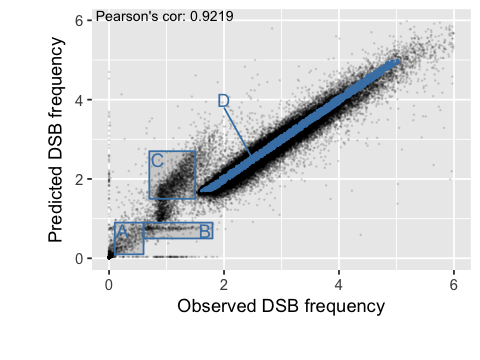

In [209]:
options(repr.plot.width=4, repr.plot.height=3)
pscat <- p
p
#ggsave(file="Figure4a.pdf", plot=pscat, path=paperfigdir, width=4, height=4, units="in")

In [210]:
mydat <- dat[xisamp,]
mytitle=paste("Group D: 1.7-5\n", "(", length(xisamp), ")", sep="")
prange <- make_heat_map(dat=mydat, featlabs=myfeat, mytitle=mytitle, ylabs=FALSE)

### Plots for Boxed regions
lims=limsA
xi <- pdat$breaks > lims[1] & pdat$breaks < lims[2] & pdat$predicted > lims[3] & pdat$predicted < lims[4]
mydat <- dat[xi,]
mytitle=paste("Box A: ", lims[1], "-", lims[2], "\n", "(", sum(xi), ")", sep="")
pboxA <- make_heat_map(dat=mydat, featlabs=myfeat, mytitle=mytitle, legend=FALSE)

lims=limsB
xi <- pdat$breaks > lims[1] & pdat$breaks < lims[2] & pdat$predicted > lims[3] & pdat$predicted < lims[4]
mydat <- dat[xi,]
mytitle=paste("Box B: ", lims[1], "-", lims[2], "\n", "(", sum(xi), ")", sep="")
pboxB <- make_heat_map(dat=mydat, featlabs=myfeat, mytitle=mytitle, legend=TRUE, ylabs=FALSE)

lims=limsC
xi <- pdat$breaks > lims[1] & pdat$breaks < lims[2] & pdat$predicted > lims[3] & pdat$predicted < lims[4]
mydat <- dat[xi,]
mytitle=paste("Box C: ", lims[1], "-", lims[2], "\n", "(", sum(xi), ")", sep="")
pboxC <- make_heat_map(dat=mydat, featlabs=myfeat, mytitle=mytitle, legend=FALSE, ylabs=TRUE)


In [ ]:
ps <- add_corner_label(pscat, "a")
gAB <- arrangeGrob(grobs=c(list(pboxA), list(pboxB)), ncol=2, widths=c(2.5,2.2))
gAB <- add_corner_label(gAB, "b")
gtop <- arrangeGrob(grobs=c(list(ps), list(gAB)), ncol=2, widths=c(3.5,5))
gCD <- arrangeGrob(grobs=c(list(pboxC), list(prange)), ncol=2, widths=c(3,6))
gCD <- add_corner_label(gCD, "c")
options(repr.plot.width=8, repr.plot.height=7)
g4 <- grid.arrange(gtop, gCD, nrow=2)

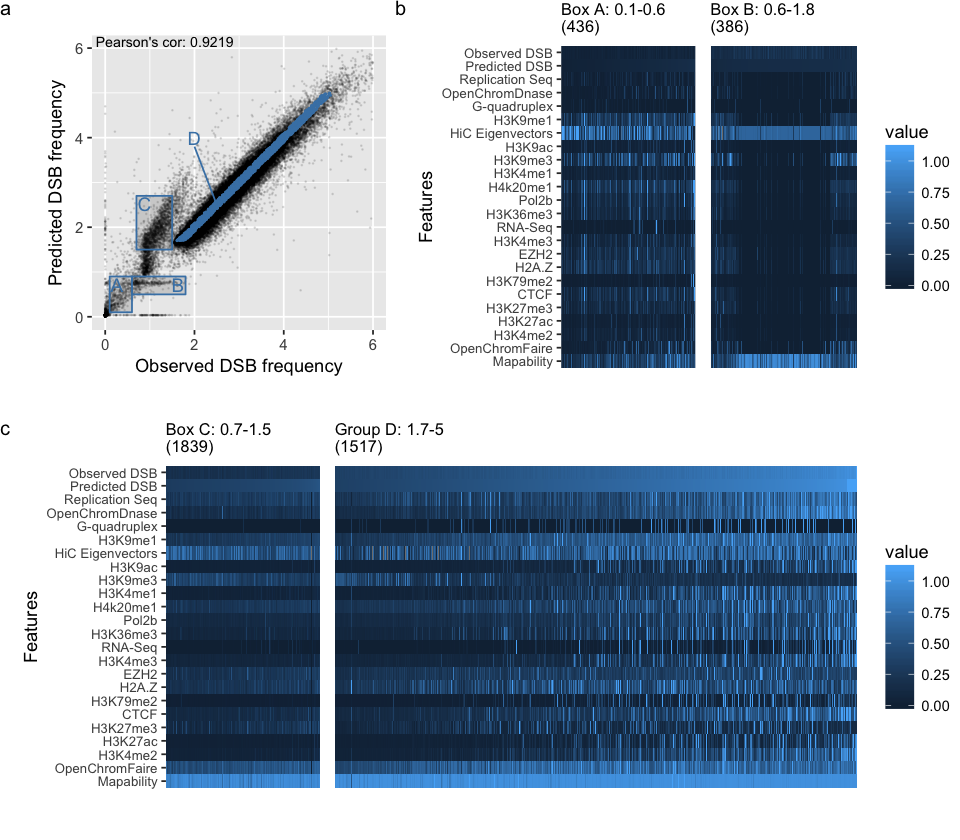

In [213]:
ggsave(file="Extended_NHEK_heatmap.pdf", plot=g4, path=supfigdir, width=8, height=7, units="in")
ggsave(file="Extended_NHEK_heatmap.png", plot=g4, path=supfigdir, width=8, height=7, units="in", dpi=600)

# Tissue type specific hotspots boxplots

### Functions

In [214]:
get_cutoffs_from_perc <- function(y, svcf){
    num= round(length(y[y>0])*svcf)
    cf = sort(y, decreasing=TRUE)[num]
    return(cf)
}

make_tissue_type_boxdata <- function(pdat, pcf=0.01, types=NULL, cntdat=NULL, nulli=5){
    nullcnt = cntdat[,nulli]
    dfnull = data.frame(dat=pdat[nullcnt>0], label=names(cntdat)[nulli])
    dfbox = dfnull
    kstests = c()
    for (mylabel in types) {
        rcnts <- cntdat[,which(names(cntdat)==mylabel)]
        cf = get_cutoffs_from_perc(rcnts, pcf)
        mydf = data.frame(dat = pdat[rcnts >= cf], label=mylabel)
        dfbox = data.frame(rbind(dfbox, mydf))
        kstests = c(kstests, ks.test(mydf$dat, dfnull$dat, alternative="less")$p.value)
    }    
    return(list(dfbox, kstests))
}

make_tissue_type_boxdata2 <- function(pdat, pcf=0.01, types=NULL, cntdat=NULL, nulli=5){
    nullcnt = cntdat[,nulli]
    dfnull = data.frame(dat=pdat[nullcnt>0], label=paste0(names(cntdat[nulli]), "_null"))
    dfbox = dfnull
    wctests = c(1)
    for (mylabel in types) {
        rcnts <- cntdat[,which(names(cntdat)==mylabel)]
        cf = get_cutoffs_from_perc(rcnts, pcf)
        mydf = data.frame(dat = pdat[rcnts >= cf], label=mylabel)
        mydfn = data.frame(dat = pdat[rcnts < cf & nullcnt>0], label=paste0(mylabel, "_null"))
        dfbox = data.frame(rbind(dfbox, mydf))
        wctests = c(wctests, wilcox.test(mydf$dat, mydfn$dat, alternative="greater")$p.value)
    }
    return(list(dfbox, wctests))
}

make_tissue_type_boxplots <- function(dfbox, myks, mycols=c("grey", brewer.pal(8,"Paired")), xl=10){
    mylabs=rle(as.character(dfbox$label))$values
    newlabs=c()
    for (i in seq_along(mylabs)){
        newl = paste0(mylabs[i], "\n(", prettyNum(sum(dfbox$label== mylabs[i]), big.mark=",", scientific=TRUE), ")")
        newlabs=c(newlabs, newl)
    }
    pbox <- ggplot(dfbox, aes(x=label, y=dat)) + 
    geom_boxplot(colour=mycols, fill=mycols, alpha=0.5, outlier.colour=NULL) + 
    labs(x="", y="Predicted DSB frequency") + ylim(0,xl) + 
    scale_x_discrete(labels=newlabs) + 
    theme(axis.text.x = element_text(angle = 90, hjust=0.5, vjust=0.5)) + 
    annotate("text", x=seq(1,(length(myks))), y=xl, label=unlist(lapply(myks, make_into_stars)))
    return(pbox)
}

make_tissue_type_violinplots <- function(dfbox, myks, mycols=c("grey", brewer.pal(8,"Paired")), xl=10){
    mylabs=rle(as.character(dfbox$label))$values
    newlabs=c()
    for (i in seq_along(mylabs)){
        newl = paste0(mylabs[i], "\n(", prettyNum(sum(dfbox$label== mylabs[i]), big.mark=",", scientific=TRUE), ")")
        newlabs=c(newlabs, newl)
    }
    pbox <- ggplot(dfbox, aes(x=label, y=dat)) + geom_violin() + 
    geom_boxplot(colour=mycols, fill=mycols, alpha=0.5, outlier.colour=NULL, width=0.2) + 
    labs(x="", y="Predicted DSB frequency") + ylim(0,xl) + 
    scale_x_discrete(labels=newlabs) + 
    theme(axis.text.x = element_text(angle = 90, hjust=0.5, vjust=0.5)) + 
    annotate("text", x=seq(1,(length(myks))), y=xl, label=unlist(lapply(myks, make_into_stars)))
    return(pbox)
}

## TCGA hotspots by tissue type

### Boxplots

In [77]:
dat <- read.table("cancer_bkpts/tcga/tcga_bytype_realcnts.txt", header=TRUE)
names(dat) <- sub("TCGA.", "", names(dat))
mynull=15
mytypes=c("PANC.all", "KERA.all", "BLOD.all", "BRCA.all")
myc = c("grey", brewer.pal(8, "Paired")[c(2,4,6,8)])
mypcf=0.01

moddat <- read.table("DSBCapture/results_Nhek6/GSM20687556_BREAK/predicted.txt", header=TRUE)
bd <- make_tissue_type_boxdata2(pdat=moddat$predicted, pcf=mypcf, types=mytypes, cntdat=dat, nulli=mynull)
pbox1 <- make_tissue_type_boxplots(bd[[1]], bd[[2]], mycols=myc, xl=7) + ggtitle("NHEK")

moddat <- read.table("BLISS/results_K562_mNhek6/rm106_CATCACGC_q30_chr-loc-countDifferentUMI/predicted.txt", header=TRUE)
bd <- make_tissue_type_boxdata2(pdat=moddat$predicted, pcf=mypcf, types=mytypes, cntdat=dat, nulli=mynull)
pbox2 <- make_tissue_type_boxplots(bd[[1]], bd[[2]], mycols=myc, xl=0.002) + ggtitle("K562")

moddat <- read.table("MCF7_BICRO63/results_Mcf7_mNhek6/RM181921/predicted.txt", header=TRUE)
bd <- make_tissue_type_boxdata2(pdat=moddat$predicted, pcf=mypcf, types=mytypes, cntdat=dat, nulli=mynull)
pbox3 <- make_tissue_type_boxplots(bd[[1]], bd[[2]], mycols=myc, xl=0.03) + ggtitle("MCF7")

options(repr.plot.width=8, repr.plot.height=3)
g1 <- arrangeGrob(pbox1, pbox2, pbox3, ncol=3, top="p-value 0.01 hotspots")

Warning message:
“Removed 17 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 147 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 294 rows containing non-finite values (stat_boxplot).”

In [78]:
dat <- read.table("cancer_bkpts/tcga/tcga_bytype_realcnts.txt", header=TRUE)
names(dat) <- sub("TCGA.", "", names(dat))
mynull=15
mytypes=c("PANC.all", "KERA.all", "BLOD.all", "BRCA.all")
myc = c("grey", brewer.pal(8, "Paired")[c(2,4,6,8)])
mypcf=0.05

moddat <- read.table("DSBCapture/results_Nhek6/GSM20687556_BREAK/predicted.txt", header=TRUE)
bd <- make_tissue_type_boxdata2(pdat=moddat$predicted, pcf=mypcf, types=mytypes, cntdat=dat, nulli=mynull)
pbox1 <- make_tissue_type_boxplots(bd[[1]], bd[[2]], mycols=myc, xl=7) + ggtitle("NHEK")

moddat <- read.table("BLISS/results_K562_mNhek6/rm106_CATCACGC_q30_chr-loc-countDifferentUMI/predicted.txt", header=TRUE)
bd <- make_tissue_type_boxdata2(pdat=moddat$predicted, pcf=mypcf, types=mytypes, cntdat=dat, nulli=mynull)
pbox2 <- make_tissue_type_boxplots(bd[[1]], bd[[2]], mycols=myc, xl=0.002) + ggtitle("K562")

moddat <- read.table("MCF7_BICRO63/results_Mcf7_mNhek6/RM181921/predicted.txt", header=TRUE)
bd <- make_tissue_type_boxdata2(pdat=moddat$predicted, pcf=mypcf, types=mytypes, cntdat=dat, nulli=mynull)
pbox3 <- make_tissue_type_boxplots(bd[[1]], bd[[2]], mycols=myc, xl=0.03) + ggtitle("MCF7")

options(repr.plot.width=8, repr.plot.height=3)
g5 <- arrangeGrob(pbox1, pbox2, pbox3, ncol=3, top="p-value 0.05 hotspots")

Warning message:
“Removed 17 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 159 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 333 rows containing non-finite values (stat_boxplot).”

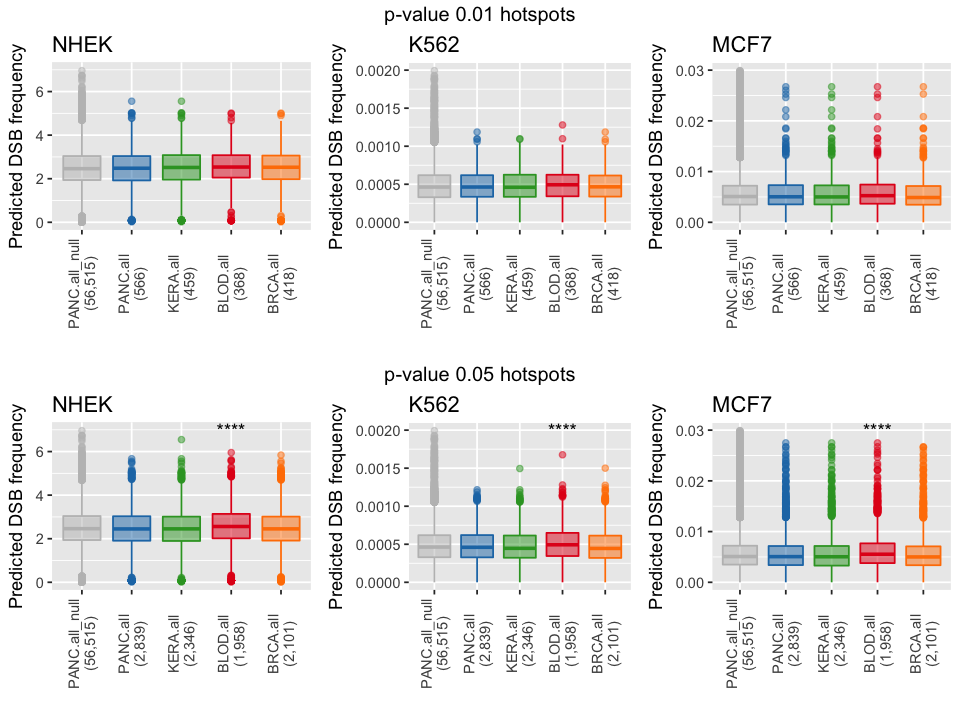

In [79]:
options(repr.plot.width=8, repr.plot.height=6)
grid.arrange(g1, g5, nrow=2)

### Violin plots

In [80]:
dat <- read.table("cancer_bkpts/tcga/tcga_bytype_realcnts.txt", header=TRUE)
names(dat) <- sub("TCGA.", "", names(dat))
mynull=15
mytypes=c("PANC.all", "KERA.all", "BLOD.all", "BRCA.all")
myc = c("grey", brewer.pal(8, "Paired")[c(2,4,6,8)])
mypcf=0.01

moddat <- read.table("DSBCapture/results_Nhek6/GSM20687556_BREAK/predicted.txt", header=TRUE)
bd <- make_tissue_type_boxdata2(pdat=moddat$predicted, pcf=mypcf, types=mytypes, cntdat=dat, nulli=mynull)
pbox1 <- make_tissue_type_violinplots(bd[[1]], bd[[2]], mycols=myc, xl=7) + ggtitle("NHEK")

moddat <- read.table("BLISS/results_K562_mNhek6/rm106_CATCACGC_q30_chr-loc-countDifferentUMI/predicted.txt", header=TRUE)
bd <- make_tissue_type_boxdata2(pdat=moddat$predicted, pcf=mypcf, types=mytypes, cntdat=dat, nulli=mynull)
pbox2 <- make_tissue_type_violinplots(bd[[1]], bd[[2]], mycols=myc, xl=0.002) + ggtitle("K562")

moddat <- read.table("MCF7_BICRO63/results_Mcf7_mNhek6/RM181921/predicted.txt", header=TRUE)
bd <- make_tissue_type_boxdata2(pdat=moddat$predicted, pcf=mypcf, types=mytypes, cntdat=dat, nulli=mynull)
pbox3 <- make_tissue_type_violinplots(bd[[1]], bd[[2]], mycols=myc, xl=0.03) + ggtitle("MCF7")

g1 <- arrangeGrob(pbox1, pbox2, pbox3, ncol=3, top="p-value 0.01 hotspots")

Warning message:
“Removed 17 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 17 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 147 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 147 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 294 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 294 rows containing non-finite values (stat_boxplot).”

In [82]:
dat <- read.table("cancer_bkpts/tcga/tcga_bytype_realcnts.txt", header=TRUE)
names(dat) <- sub("TCGA.", "", names(dat))
mynull=15
mytypes=c("PANC.all", "KERA.all", "BLOD.all", "BRCA.all")
myc = c("grey", brewer.pal(8, "Paired")[c(2,4,6,8)])
mypcf=0.05

moddat <- read.table("DSBCapture/results_Nhek6/GSM20687556_BREAK/predicted.txt", header=TRUE)
bd <- make_tissue_type_boxdata2(pdat=moddat$predicted, pcf=mypcf, types=mytypes, cntdat=dat, nulli=mynull)
pbox1 <- make_tissue_type_violinplots(bd[[1]], bd[[2]], mycols=myc, xl=7) + ggtitle("NHEK")

moddat <- read.table("BLISS/results_K562_mNhek6/rm106_CATCACGC_q30_chr-loc-countDifferentUMI/predicted.txt", header=TRUE)
bd <- make_tissue_type_boxdata2(pdat=moddat$predicted, pcf=mypcf, types=mytypes, cntdat=dat, nulli=mynull)
pbox2 <- make_tissue_type_violinplots(bd[[1]], bd[[2]], mycols=myc, xl=0.002) + ggtitle("K562")

moddat <- read.table("MCF7_BICRO63/results_Mcf7_mNhek6/RM181921/predicted.txt", header=TRUE)
bd <- make_tissue_type_boxdata2(pdat=moddat$predicted, pcf=mypcf, types=mytypes, cntdat=dat, nulli=mynull)
pbox3 <- make_tissue_type_violinplots(bd[[1]], bd[[2]], mycols=myc, xl=0.03) + ggtitle("MCF7")

options(repr.plot.width=8, repr.plot.height=3)
g5 <- arrangeGrob(pbox1, pbox2, pbox3, ncol=3, top="p-value 0.05 hotspots")

Warning message:
“Removed 17 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 17 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 159 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 159 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 333 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 333 rows containing non-finite values (stat_boxplot).”

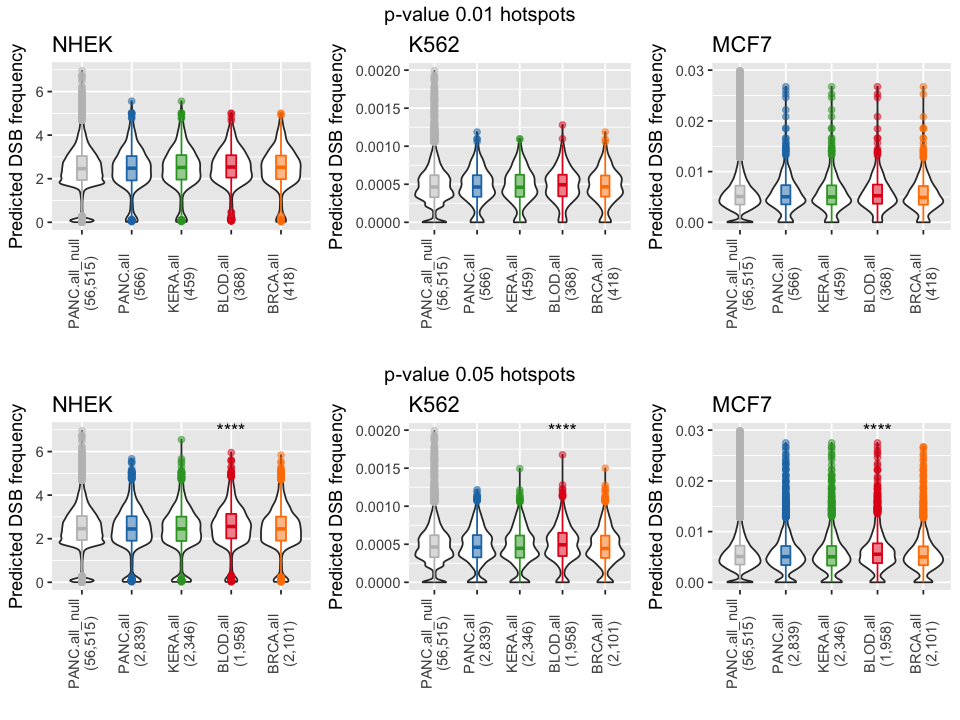

In [83]:
options(repr.plot.width=8, repr.plot.height=6)
grid.arrange(g1, g5, nrow=2)

### Per tissue and CNV type

In [65]:
dat <- read.table("cancer_bkpts/tcga/tcga_bytype_realcnts.txt", header=TRUE)
names(dat) <- sub("TCGA.", "", names(dat))
mynull=15
mytypes=c("PANC.amp", "PANC.del", "KERA.amp", "KERA.del", "BLOD.amp", "BLOD.del", "BRCA.amp", "BRCA.del")
myc = c("grey", brewer.pal(8, "Paired"))
mypcf=0.01

moddat <- read.table("DSBCapture/results_Nhek6/GSM20687556_BREAK/predicted.txt", header=TRUE)
bd <- make_tissue_type_boxdata2(pdat=moddat$predicted, pcf=mypcf, types=mytypes, cntdat=dat, nulli=mynull)
pbox1 <- make_tissue_type_violinplots(bd[[1]], bd[[2]], mycols=myc, xl=7) + ggtitle("NHEK")

moddat <- read.table("BLISS/results_K562_mNhek6/rm106_CATCACGC_q30_chr-loc-countDifferentUMI/predicted.txt", header=TRUE)
bd <- make_tissue_type_boxdata2(pdat=moddat$predicted, pcf=mypcf, types=mytypes, cntdat=dat, nulli=mynull)
pbox2 <- make_tissue_type_violinplots(bd[[1]], bd[[2]], mycols=myc, xl=0.002) + ggtitle("K562")

moddat <- read.table("MCF7_BICRO63/results_Mcf7_mNhek6/RM181921/predicted.txt", header=TRUE)
bd <- make_tissue_type_boxdata2(pdat=moddat$predicted, pcf=mypcf, types=mytypes, cntdat=dat, nulli=mynull)
pbox3 <- make_tissue_type_violinplots(bd[[1]], bd[[2]], mycols=myc, xl=0.03) + ggtitle("MCF7")

options(repr.plot.width=8, repr.plot.height=3)
g1 <- arrangeGrob(pbox1, pbox2, pbox3, ncol=3, top="p-value 0.01 hotspots")

Warning message:
“Removed 17 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 17 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 147 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 147 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 303 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 303 rows containing non-finite values (stat_boxplot).”

In [66]:
dat <- read.table("cancer_bkpts/tcga/tcga_bytype_realcnts.txt", header=TRUE)
names(dat) <- sub("TCGA.", "", names(dat))
mynull=15
mytypes=c("PANC.amp", "PANC.del", "KERA.amp", "KERA.del", "BLOD.amp", "BLOD.del", "BRCA.amp", "BRCA.del")
myc = c("grey", brewer.pal(8, "Paired"))
mypcf=0.05

moddat <- read.table("DSBCapture/results_Nhek6/GSM20687556_BREAK/predicted.txt", header=TRUE)
bd <- make_tissue_type_boxdata2(pdat=moddat$predicted, pcf=mypcf, types=mytypes, cntdat=dat, nulli=mynull)
pbox1 <- make_tissue_type_violinplots(bd[[1]], bd[[2]], mycols=myc, xl=7) + ggtitle("NHEK")

moddat <- read.table("BLISS/results_K562_mNhek6/rm106_CATCACGC_q30_chr-loc-countDifferentUMI/predicted.txt", header=TRUE)
bd <- make_tissue_type_boxdata2(pdat=moddat$predicted, pcf=mypcf, types=mytypes, cntdat=dat, nulli=mynull)
pbox2 <- make_tissue_type_violinplots(bd[[1]], bd[[2]], mycols=myc, xl=0.002) + ggtitle("K562")

moddat <- read.table("MCF7_BICRO63/results_Mcf7_mNhek6/RM181921/predicted.txt", header=TRUE)
bd <- make_tissue_type_boxdata2(pdat=moddat$predicted, pcf=mypcf, types=mytypes, cntdat=dat, nulli=mynull)
pbox3 <- make_tissue_type_violinplots(bd[[1]], bd[[2]], mycols=myc, xl=0.03) + ggtitle("MCF7")

options(repr.plot.width=8, repr.plot.height=3)
g5 <- arrangeGrob(pbox1, pbox2, pbox3, ncol=3, top="p-value 0.05 hotspots")

Warning message:
“Removed 17 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 17 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 163 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 163 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 360 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 360 rows containing non-finite values (stat_boxplot).”

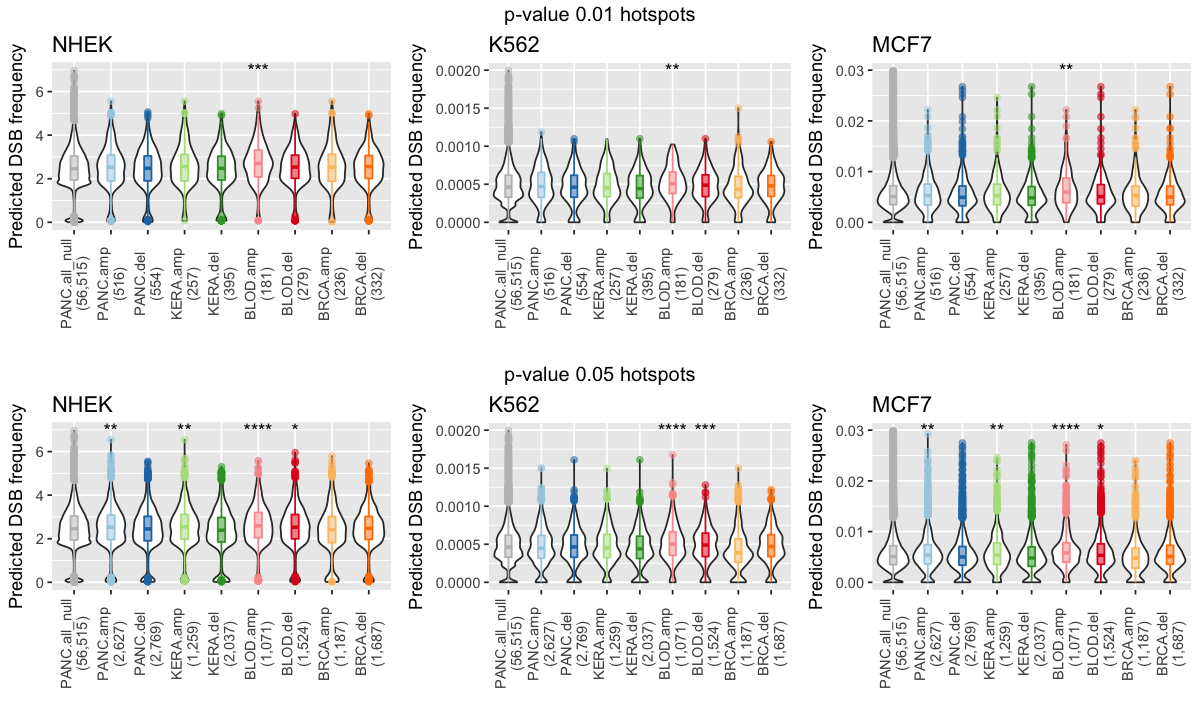

In [68]:
options(repr.plot.width=10, repr.plot.height=6)
grid.arrange(g1, g5, nrow=2)

## ICGC hotspots by tissue type

### Any breakpoint

In [104]:
brdat <- read.table("cancer_bkpts/icgc/brca_realcnts.txt", header=TRUE)
bldat <- read.table("cancer_bkpts/icgc/blood_realcnts.txt", header=TRUE)
skdat <- read.table("cancer_bkpts/icgc/skin_realcnts.txt", header=TRUE)
cadat <- read.table("cancer_bkpts/icgc/carc_realcnts.txt", header=TRUE)
dat <- data.frame(panc= brdat$any + bldat$any + skdat$any, breast=brdat$any, 
    blood= bldat$any, skin=skdat$any, carcinoma=cadat$any, nonbreast=cadat$any-brdat$any)

In [106]:
mynull=1
mytypes=c("carcinoma","nonbreast", "blood", "breast")
myc = c("grey", brewer.pal(10, "Paired")[c(2,4,6,8)])
mypcf=0.01

moddat <- read.table("DSBCapture/results_Nhek6/GSM20687556_BREAK/predicted.txt", header=TRUE)
bd <- make_tissue_type_boxdata2(pdat=moddat$predicted, pcf=mypcf, types=mytypes, cntdat=dat, nulli=mynull)
pbox1 <- make_tissue_type_violinplots(bd[[1]], bd[[2]], mycols=myc, xl=7) + ggtitle("NHEK")

moddat <- read.table("BLISS/results_K562_mNhek6/rm106_CATCACGC_q30_chr-loc-countDifferentUMI/predicted.txt", header=TRUE)
bd <- make_tissue_type_boxdata2(pdat=moddat$predicted, pcf=mypcf, types=mytypes, cntdat=dat, nulli=mynull)
pbox2 <- make_tissue_type_violinplots(bd[[1]], bd[[2]], mycols=myc, xl=0.002) + ggtitle("K562")

moddat <- read.table("MCF7_BICRO63/results_Mcf7_mNhek6/RM181921/predicted.txt", header=TRUE)
bd <- make_tissue_type_boxdata2(pdat=moddat$predicted, pcf=mypcf, types=mytypes, cntdat=dat, nulli=mynull)
pbox3 <- make_tissue_type_violinplots(bd[[1]], bd[[2]], mycols=myc, xl=0.03) + ggtitle("MCF7")

g1 <- arrangeGrob(pbox1, pbox2, pbox3, ncol=3, top="p-value 0.01 hotspots")

mypcf=0.05
moddat <- read.table("DSBCapture/results_Nhek6/GSM20687556_BREAK/predicted.txt", header=TRUE)
bd <- make_tissue_type_boxdata2(pdat=moddat$predicted, pcf=mypcf, types=mytypes, cntdat=dat, nulli=mynull)
pbox1 <- make_tissue_type_violinplots(bd[[1]], bd[[2]], mycols=myc, xl=7) + ggtitle("NHEK")

moddat <- read.table("BLISS/results_K562_mNhek6/rm106_CATCACGC_q30_chr-loc-countDifferentUMI/predicted.txt", header=TRUE)
bd <- make_tissue_type_boxdata2(pdat=moddat$predicted, pcf=mypcf, types=mytypes, cntdat=dat, nulli=mynull)
pbox2 <- make_tissue_type_violinplots(bd[[1]], bd[[2]], mycols=myc, xl=0.002) + ggtitle("K562")

moddat <- read.table("MCF7_BICRO63/results_Mcf7_mNhek6/RM181921/predicted.txt", header=TRUE)
bd <- make_tissue_type_boxdata2(pdat=moddat$predicted, pcf=mypcf, types=mytypes, cntdat=dat, nulli=mynull)
pbox3 <- make_tissue_type_violinplots(bd[[1]], bd[[2]], mycols=myc, xl=0.03) + ggtitle("MCF7")

g5 <- arrangeGrob(pbox1, pbox2, pbox3, ncol=3, top="p-value 0.05 hotspots")

Warning message:
“Removed 16 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 16 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 133 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 133 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 275 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 275 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 19 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 19 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 150 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 150 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 324 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 324 rows containing non-finite values (stat_boxplot).”

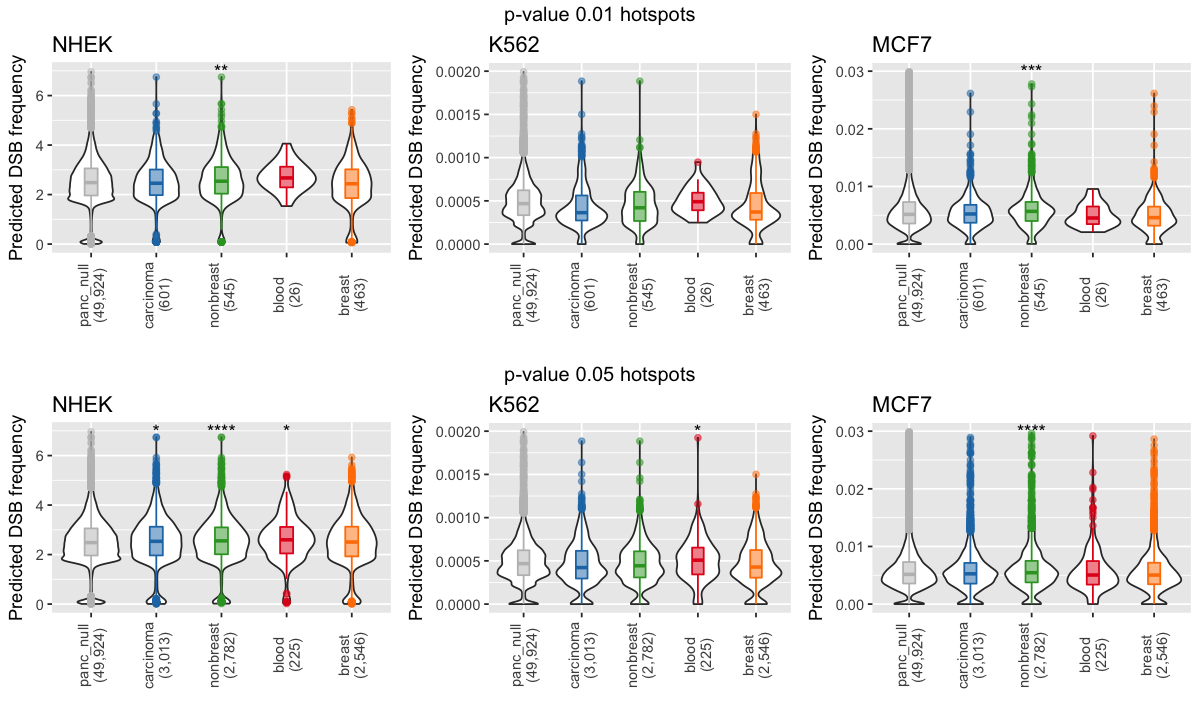

In [107]:
options(repr.plot.width=10, repr.plot.height=6)
grid.arrange(g1, g5, nrow=2)

In blood cancers, DSB hotspots are more DSB susceptible than skin or breast cancer DSB hotspots.  There are two reasons why this might be.  One is that solid tissue cancers may have chromatin states and nuclear organization differing from normal tissues, so that our models, based on non-cancer cells, do not accurately describe the DSB susceptibility of cancer cells.  Solid state tumours have many more mutations in general than blood cancers, potentially indicating a longer progression of the disease and certainly a more divergent genomic state from the healthy tissue.  The second reason most cancers' DSB hotspots are not significantly more prone to DSB, given our model, is because there are selective forces acting on the cancer cell in addition to the inherent DSB susceptibility of the nascent cell.  Namely, oncogenic mutations in cancers often involve the amplification or deletion of proto-ongogenes or tumor suppressors, so the DSB hotspots tied to CNV events have increased DSB not because they are prone to break, but because the neighboring sequence is prone to copy number variation.  Blood cancers are exceptional for their lack of CNV, 

### Interchr

In [89]:
brdat <- read.table("cancer_bkpts/icgc/brca_realcnts.txt", header=TRUE)
bldat <- read.table("cancer_bkpts/icgc/blood_realcnts.txt", header=TRUE)
skdat <- read.table("cancer_bkpts/icgc/skin_realcnts.txt", header=TRUE)
dat <- data.frame(panc= brdat$any + bldat$any + skdat$any, 
                  breast=brdat$interchr, blood= bldat$interchr, skin=skdat$interchr)

In [90]:
mynull=1
mytypes=c("panc", "skin", "blood", "breast")
myc = c("grey", brewer.pal(8, "Paired")[c(2,4,6,8)])
mypcf=0.01

moddat <- read.table("DSBCapture/results_Nhek6/GSM20687556_BREAK/predicted.txt", header=TRUE)
bd <- make_tissue_type_boxdata2(pdat=moddat$predicted, pcf=mypcf, types=mytypes, cntdat=dat, nulli=mynull)
pbox1 <- make_tissue_type_violinplots(bd[[1]], bd[[2]], mycols=myc, xl=7) + ggtitle("NHEK")

moddat <- read.table("BLISS/results_K562_mNhek6/rm106_CATCACGC_q30_chr-loc-countDifferentUMI/predicted.txt", header=TRUE)
bd <- make_tissue_type_boxdata2(pdat=moddat$predicted, pcf=mypcf, types=mytypes, cntdat=dat, nulli=mynull)
pbox2 <- make_tissue_type_violinplots(bd[[1]], bd[[2]], mycols=myc, xl=0.002) + ggtitle("K562")

moddat <- read.table("MCF7_BICRO63/results_Mcf7_mNhek6/RM181921/predicted.txt", header=TRUE)
bd <- make_tissue_type_boxdata2(pdat=moddat$predicted, pcf=mypcf, types=mytypes, cntdat=dat, nulli=mynull)
pbox3 <- make_tissue_type_violinplots(bd[[1]], bd[[2]], mycols=myc, xl=0.03) + ggtitle("MCF7")

g1 <- arrangeGrob(pbox1, pbox2, pbox3, ncol=3, top="p-value 0.01 hotspots")

Warning message:
“Removed 16 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 16 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 132 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 132 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 269 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 269 rows containing non-finite values (stat_boxplot).”

In [91]:
mypcf=0.05
moddat <- read.table("DSBCapture/results_Nhek6/GSM20687556_BREAK/predicted.txt", header=TRUE)
bd <- make_tissue_type_boxdata2(pdat=moddat$predicted, pcf=mypcf, types=mytypes, cntdat=dat, nulli=mynull)
pbox1 <- make_tissue_type_violinplots(bd[[1]], bd[[2]], mycols=myc, xl=7) + ggtitle("NHEK")

moddat <- read.table("BLISS/results_K562_mNhek6/rm106_CATCACGC_q30_chr-loc-countDifferentUMI/predicted.txt", header=TRUE)
bd <- make_tissue_type_boxdata2(pdat=moddat$predicted, pcf=mypcf, types=mytypes, cntdat=dat, nulli=mynull)
pbox2 <- make_tissue_type_violinplots(bd[[1]], bd[[2]], mycols=myc, xl=0.002) + ggtitle("K562")

moddat <- read.table("MCF7_BICRO63/results_Mcf7_mNhek6/RM181921/predicted.txt", header=TRUE)
bd <- make_tissue_type_boxdata2(pdat=moddat$predicted, pcf=mypcf, types=mytypes, cntdat=dat, nulli=mynull)
pbox3 <- make_tissue_type_violinplots(bd[[1]], bd[[2]], mycols=myc, xl=0.03) + ggtitle("MCF7")

g5 <- arrangeGrob(pbox1, pbox2, pbox3, ncol=3, top="p-value 0.05 hotspots")

Warning message:
“Removed 17 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 17 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 140 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 140 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 280 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 280 rows containing non-finite values (stat_boxplot).”

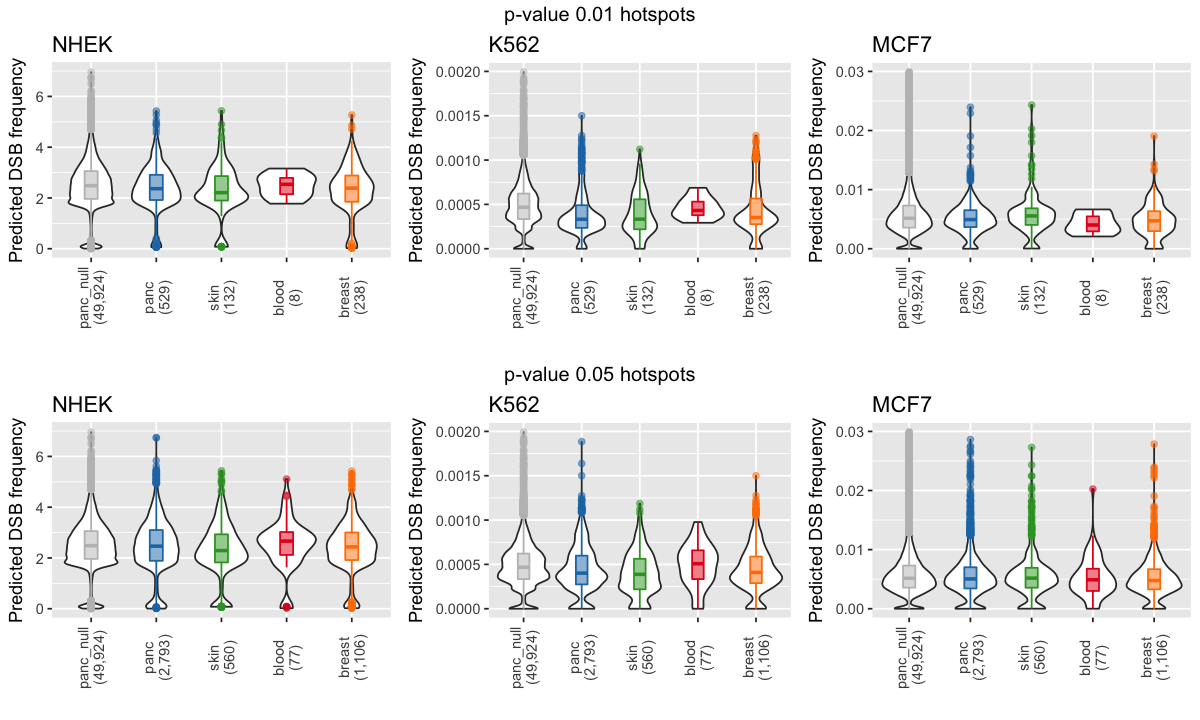

In [92]:
options(repr.plot.width=10, repr.plot.height=6)
grid.arrange(g1, g5, nrow=2)

### By SV type PANC

In [93]:
dat <- read.table("cancer_bkpts/icgc/panc_realcnts.txt", header=TRUE)

In [95]:
mynull=5
mytypes=c("any", "deletion", "duplication", "insertion", "interchr", "intrachr", "inversion", "translocation")
myc = c("grey", brewer.pal(8, "Paired"))
mypcf=0.01

moddat <- read.table("DSBCapture/results_Nhek6/GSM20687556_BREAK/predicted.txt", header=TRUE)
bd <- make_tissue_type_boxdata2(pdat=moddat$predicted, pcf=mypcf, types=mytypes, cntdat=dat, nulli=mynull)
pbox1 <- make_tissue_type_violinplots(bd[[1]], bd[[2]], mycols=myc, xl=7) + ggtitle("NHEK")

moddat <- read.table("BLISS/results_K562_mNhek6/rm106_CATCACGC_q30_chr-loc-countDifferentUMI/predicted.txt", header=TRUE)
bd <- make_tissue_type_boxdata2(pdat=moddat$predicted, pcf=mypcf, types=mytypes, cntdat=dat, nulli=mynull)
pbox2 <- make_tissue_type_violinplots(bd[[1]], bd[[2]], mycols=myc, xl=0.002) + ggtitle("K562")

moddat <- read.table("MCF7_BICRO63/results_Mcf7_mNhek6/RM181921/predicted.txt", header=TRUE)
bd <- make_tissue_type_boxdata2(pdat=moddat$predicted, pcf=mypcf, types=mytypes, cntdat=dat, nulli=mynull)
pbox3 <- make_tissue_type_violinplots(bd[[1]], bd[[2]], mycols=myc, xl=0.03) + ggtitle("MCF7")

g1 <- arrangeGrob(pbox1, pbox2, pbox3, ncol=3, top="p-value 0.01 hotspots")

Warning message:
“Removed 17 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 17 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 144 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 144 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 296 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 296 rows containing non-finite values (stat_boxplot).”

In [96]:
mynull=5
mytypes=c("any", "deletion", "duplication", "insertion", "interchr", "intrachr", "inversion", "translocation")
myc = c("grey", brewer.pal(8, "Paired"))
mypcf=0.05

moddat <- read.table("DSBCapture/results_Nhek6/GSM20687556_BREAK/predicted.txt", header=TRUE)
bd <- make_tissue_type_boxdata2(pdat=moddat$predicted, pcf=mypcf, types=mytypes, cntdat=dat, nulli=mynull)
pbox1 <- make_tissue_type_violinplots(bd[[1]], bd[[2]], mycols=myc, xl=7) + ggtitle("NHEK")

moddat <- read.table("BLISS/results_K562_mNhek6/rm106_CATCACGC_q30_chr-loc-countDifferentUMI/predicted.txt", header=TRUE)
bd <- make_tissue_type_boxdata2(pdat=moddat$predicted, pcf=mypcf, types=mytypes, cntdat=dat, nulli=mynull)
pbox2 <- make_tissue_type_violinplots(bd[[1]], bd[[2]], mycols=myc, xl=0.002) + ggtitle("K562")

moddat <- read.table("MCF7_BICRO63/results_Mcf7_mNhek6/RM181921/predicted.txt", header=TRUE)
bd <- make_tissue_type_boxdata2(pdat=moddat$predicted, pcf=mypcf, types=mytypes, cntdat=dat, nulli=mynull)
pbox3 <- make_tissue_type_violinplots(bd[[1]], bd[[2]], mycols=myc, xl=0.03) + ggtitle("MCF7")

g5 <- arrangeGrob(pbox1, pbox2, pbox3, ncol=3, top="p-value 0.05 hotspots")

Warning message:
“Removed 23 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 23 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 173 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 173 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 364 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 364 rows containing non-finite values (stat_boxplot).”

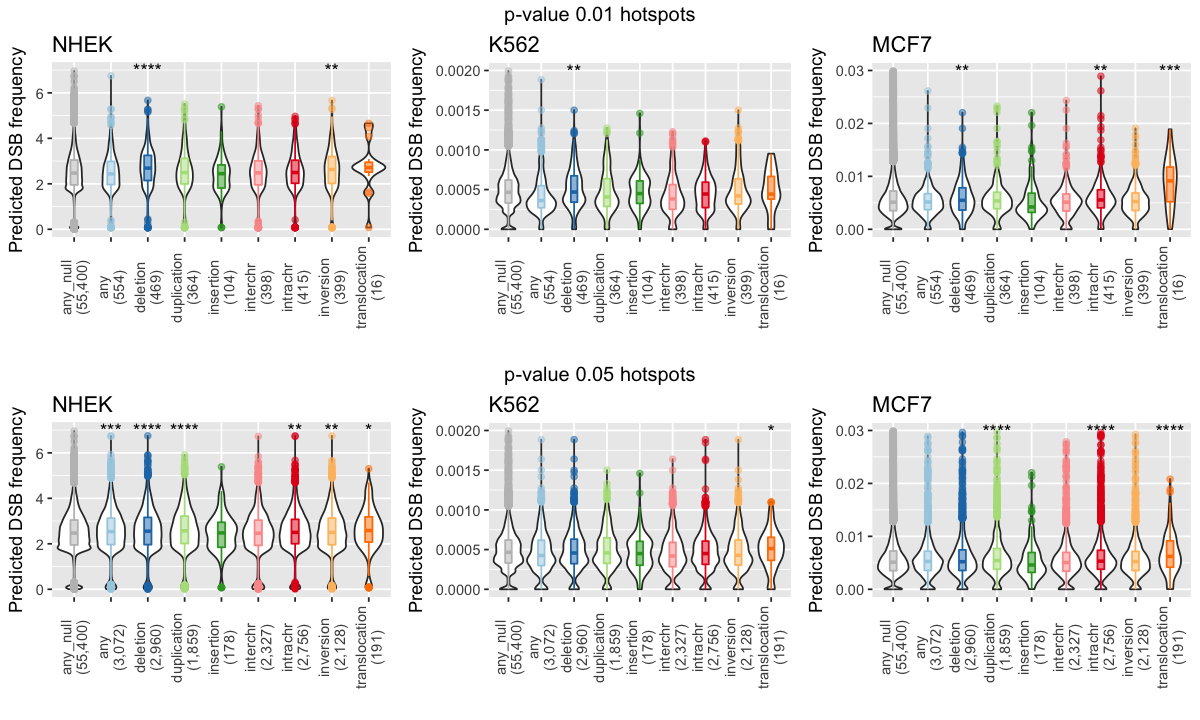

In [97]:
options(repr.plot.width=10, repr.plot.height=6)
grid.arrange(g1, g5, nrow=2)

## MCF7 by ICGC SV type

In [70]:
dat <- read.table("cancer_bkpts/icgc/brca_realcnts.txt", header=TRUE)
mynull=5
mytypes=c("deletion", "duplication", "interchr", "inversion")
myc = c("grey", brewer.pal(4, "Paired"))

moddat <- read.table("MCF7_BICRO63/results_Mcf7_mNhek6/RM181921/predicted.txt", header=TRUE)
bd <- make_tissue_type_boxdata(moddat$predicted, pcf=0.01, types=mytypes, cntdat=dat, nulli=mynull)
pbox1 <- make_tissue_type_boxplots(bd[[1]], bd[[2]], mycols=myc, xl=0.02) + ggtitle("MCF7 (p=0.01)")

bd <- make_tissue_type_boxdata(moddat$predicted, pcf=0.05, types=mytypes, cntdat=dat, nulli=mynull)
pbox2 <- make_tissue_type_boxplots(bd[[1]], bd[[2]], mycols=myc, xl=0.02) + ggtitle("MCF7 (p=0.05)")

options(repr.plot.width=6, repr.plot.height=3)
p1 <- arrangeGrob(pbox1, pbox2, ncol=2)
grid.arrange(p1)

Warning message in ks.test(mydf$dat, dfnull$dat, alternative = "less"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat, alternative = "less"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat, alternative = "less"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat, alternative = "less"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat, alternative = "less"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat, alternative = "less"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat, alternative = "less"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat, alternative = "less"):
“p-value will be approximate in the presence of ties”

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]

Warning message in ks.test(mydf$dat, dfnull$dat, alternative = "less"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat, alternative = "less"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat, alternative = "less"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat, alternative = "less"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat, alternative = "less"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat, alternative = "less"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat, alternative = "less"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat, alternative = "less"):
“p-value will be approximate in the presence of ties”

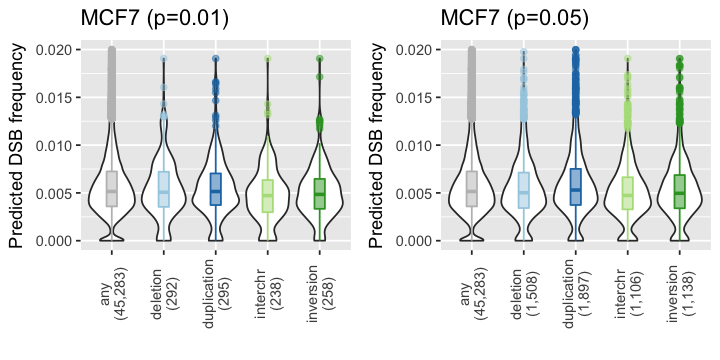

In [72]:
dat <- read.table("cancer_bkpts/icgc/brca_realcnts.txt", header=TRUE)
mynull=5
mytypes=c("deletion", "duplication", "interchr", "inversion")
myc = c("grey", brewer.pal(4, "Paired"))

moddat <- read.table("MCF7_BICRO63/results_Mcf7_mNhek6/RM181921/predicted.txt", header=TRUE)
bd <- make_tissue_type_boxdata(moddat$predicted, pcf=0.01, types=mytypes, cntdat=dat, nulli=mynull)
pbox1 <- make_tissue_type_violinplots(bd[[1]], bd[[2]], mycols=myc, xl=0.02) + ggtitle("MCF7 (p=0.01)")

bd <- make_tissue_type_boxdata(moddat$predicted, pcf=0.05, types=mytypes, cntdat=dat, nulli=mynull)
pbox2 <- make_tissue_type_violinplots(bd[[1]], bd[[2]], mycols=myc, xl=0.02) + ggtitle("MCF7 (p=0.05)")

options(repr.plot.width=6, repr.plot.height=3)
p1 <- arrangeGrob(pbox1, pbox2, ncol=2)
grid.arrange(p1)

### split by size

Warning message in ks.test(mydf$dat, dfnull$dat, alternative = "less"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat, alternative = "less"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat, alternative = "less"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat, alternative = "less"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat, alternative = "less"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat, alternative = "less"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat, alternative = "less"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat, alternative = "less"):
“p-value will be approximate in the presence of ties”

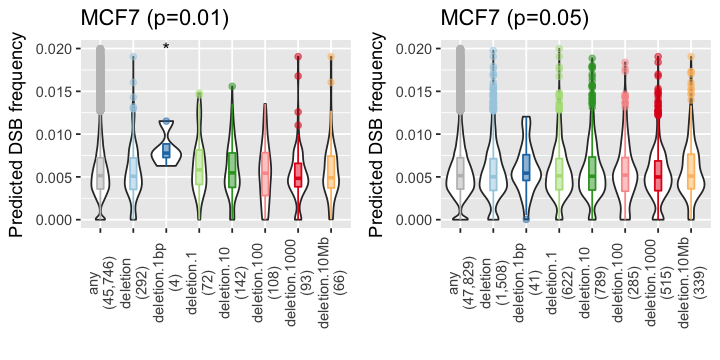

In [73]:
dat <- read.table("cancer_bkpts/icgc/brca_realcnts2.txt", header=TRUE)
mynull=5
mytypes=c("any", "deletion", "deletion.1bp", "deletion.1", "deletion.10", "deletion.100", "deletion.1000", "deletion.10Mb")
myc = c("grey", brewer.pal(7, "Paired"))

moddat <- read.table("MCF7_BICRO63/results_Mcf7_mNhek6/RM181921/predicted.txt", header=TRUE)
bd <- make_tissue_type_boxdata(moddat$predicted, pcf=0.01, types=mytypes, cntdat=dat, nulli=mynull)
pbox1 <- make_tissue_type_violinplots(bd[[1]], bd[[2]], mycols=myc, xl=0.02) + ggtitle("MCF7 (p=0.01)")

bd <- make_tissue_type_boxdata(moddat$predicted, pcf=0.05, types=mytypes, cntdat=dat, nulli=mynull)
pbox2 <- make_tissue_type_violinplots(bd[[1]], bd[[2]], mycols=myc, xl=0.02) + ggtitle("MCF7 (p=0.05)")

options(repr.plot.width=6, repr.plot.height=3)
p1 <- arrangeGrob(pbox1, pbox2, ncol=2)
grid.arrange(p1)

Warning message in ks.test(mydf$dat, dfnull$dat, alternative = "less"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat, alternative = "less"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat, alternative = "less"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat, alternative = "less"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat, alternative = "less"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat, alternative = "less"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat, alternative = "less"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat, alternative = "less"):
“p-value will be approximate in the presence of ties”

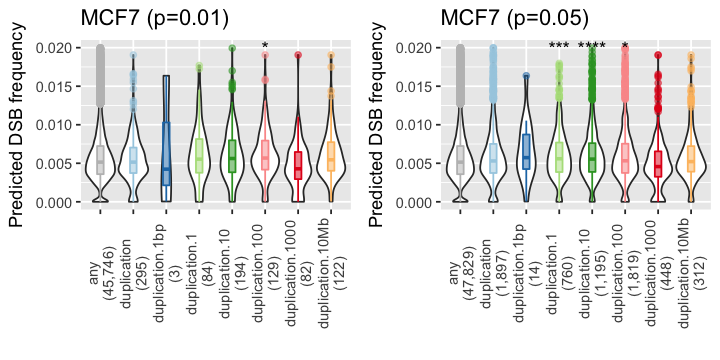

In [74]:
dat <- read.table("cancer_bkpts/icgc/brca_realcnts2.txt", header=TRUE)
mynull=5
mytypes=c("any", "duplication", "duplication.1bp", "duplication.1", "duplication.10", "duplication.100", "duplication.1000", "duplication.10Mb")
myc = c("grey", brewer.pal(7, "Paired"))

moddat <- read.table("MCF7_BICRO63/results_Mcf7_mNhek6/RM181921/predicted.txt", header=TRUE)
bd <- make_tissue_type_boxdata(moddat$predicted, pcf=0.01, types=mytypes, cntdat=dat, nulli=mynull)
pbox1 <- make_tissue_type_violinplots(bd[[1]], bd[[2]], mycols=myc, xl=0.02) + ggtitle("MCF7 (p=0.01)")

bd <- make_tissue_type_boxdata(moddat$predicted, pcf=0.05, types=mytypes, cntdat=dat, nulli=mynull)
pbox2 <- make_tissue_type_violinplots(bd[[1]], bd[[2]], mycols=myc, xl=0.02) + ggtitle("MCF7 (p=0.05)")

options(repr.plot.width=6, repr.plot.height=3)
p1 <- arrangeGrob(pbox1, pbox2, ncol=2)
grid.arrange(p1)

Warning message in ks.test(mydf$dat, dfnull$dat, alternative = "less"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat, alternative = "less"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat, alternative = "less"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat, alternative = "less"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat, alternative = "less"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat, alternative = "less"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat, alternative = "less"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat, alternative = "less"):
“p-value will be approximate in the presence of ties”

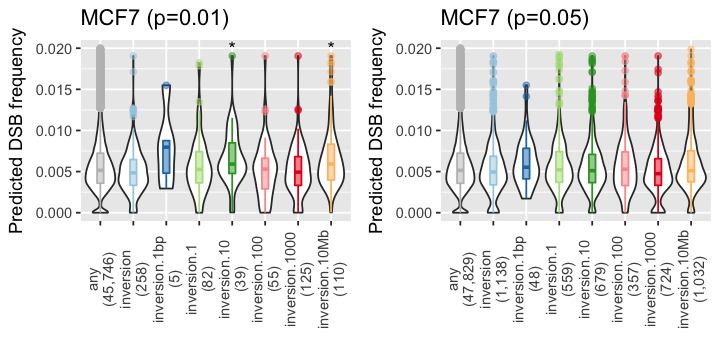

In [75]:
dat <- read.table("cancer_bkpts/icgc/brca_realcnts2.txt", header=TRUE)
mynull=5
mytypes=c("any", "inversion", "inversion.1bp", "inversion.1", "inversion.10", "inversion.100", "inversion.1000", "inversion.10Mb")
myc = c("grey", brewer.pal(7, "Paired"))

moddat <- read.table("MCF7_BICRO63/results_Mcf7_mNhek6/RM181921/predicted.txt", header=TRUE)
bd <- make_tissue_type_boxdata(moddat$predicted, pcf=0.01, types=mytypes, cntdat=dat, nulli=mynull)
pbox1 <- make_tissue_type_violinplots(bd[[1]], bd[[2]], mycols=myc, xl=0.02) + ggtitle("MCF7 (p=0.01)")

bd <- make_tissue_type_boxdata(moddat$predicted, pcf=0.05, types=mytypes, cntdat=dat, nulli=mynull)
pbox2 <- make_tissue_type_violinplots(bd[[1]], bd[[2]], mycols=myc, xl=0.02) + ggtitle("MCF7 (p=0.05)")

options(repr.plot.width=6, repr.plot.height=3)
p1 <- arrangeGrob(pbox1, pbox2, ncol=2)
grid.arrange(p1)

# Exclude regions with amp/del skew 

In [68]:
dat <- read.table("cancer_bkpts/icgc/brca_realcnts.txt", header=TRUE)
delcnt <- dat$deletion
ampcnt <- dat$duplication
totamp <- sum(ampcnt)
totdel <- sum(delcnt)
totcnt <- delcnt + ampcnt
N <- totamp + totdel
probdel <- totdel/N
pdel <- pbinom(delcnt, totcnt, prob=probdel)
pamp <- pbinom(ampcnt, totcnt, prob=1-probdel)
pbias <- pmin(pdel, pamp)


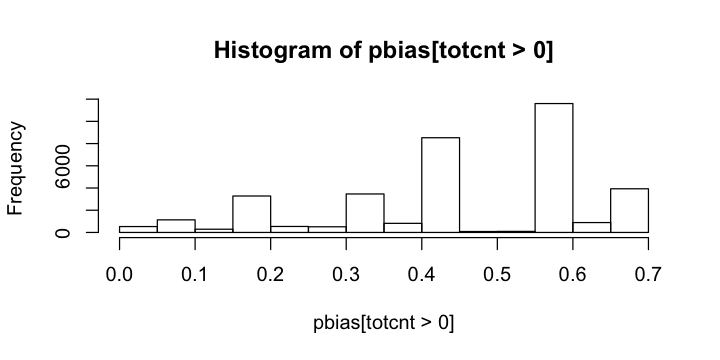

In [60]:
hist(pbias[totcnt>0])

## Regions without skew

Warning message in ks.test(mydf$dat, dfnull$dat):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat):
“p-value will be approximate in the presence of ties”Warning message:
“Removed 219 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 228 rows containing non-finite values (stat_boxplot).”

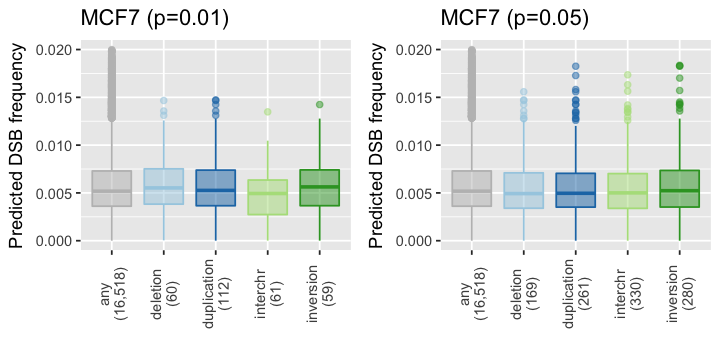

In [73]:
moddat <- read.table("MCF7_BICRO63/results_Mcf7_mNhek6/RM181921/predicted.txt", header=TRUE)
xi= pbias > 0.5 & totcnt > 0 
x <- make_tissue_type_boxdata(moddat$predicted[xi], pcf=0.01, types=mytypes, cntdat=dat[xi,], nulli=mynull)
pbox1 <- make_tissue_type_boxplots(x[[1]], x[[2]], mycols=myc, xl=0.02) + ggtitle("MCF7 (p=0.01)")

x <- make_tissue_type_boxdata(moddat$predicted[xi], pcf=0.05, types=mytypes, cntdat=dat[xi,], nulli=mynull)
pbox2 <- make_tissue_type_boxplots(x[[1]], x[[2]], mycols=myc, xl=0.02) + ggtitle("MCF7 (p=0.05)")

options(repr.plot.width=6, repr.plot.height=3)
grid.arrange(pbox1, pbox2, ncol=2)

## Regions with skew

Warning message in ks.test(mydf$dat, dfnull$dat):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat):
“p-value will be approximate in the presence of ties”Warning message:
“Removed 264 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 279 rows containing non-finite values (stat_boxplot).”

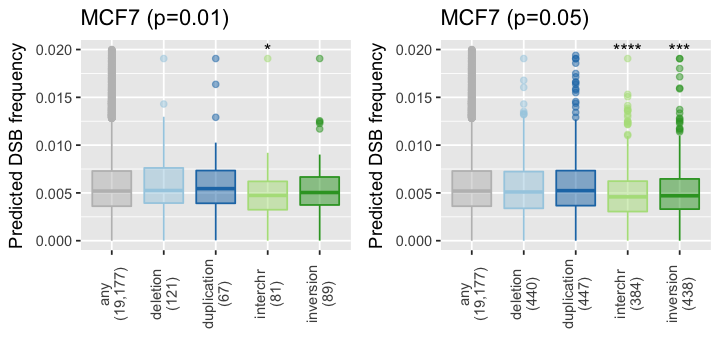

In [74]:
moddat <- read.table("MCF7_BICRO63/results_Mcf7_mNhek6/RM181921/predicted.txt", header=TRUE)
xi <- pbias <= 0.5 & totcnt > 0
mynull=5
mytypes=c("deletion", "duplication", "interchr", "inversion")
myc = c("grey", brewer.pal(4, "Paired"))

x <- make_tissue_type_boxdata(moddat$predicted[xi], pcf=0.01, types=mytypes, cntdat=dat[xi,], nulli=5)
pbox1 <- make_tissue_type_boxplots(x[[1]], x[[2]], mycols=myc, xl=0.02) + ggtitle("MCF7 (p=0.01)")

x <- make_tissue_type_boxdata(moddat$predicted[xi], pcf=0.05, types=mytypes, cntdat=dat[xi,], nulli=5)
pbox2 <- make_tissue_type_boxplots(x[[1]], x[[2]], mycols=myc, xl=0.02) + ggtitle("MCF7 (p=0.05)")

options(repr.plot.width=6, repr.plot.height=3)
grid.arrange(pbox1, pbox2, ncol=2)

## Multinomial skew (amp vs del vs inv, etc)

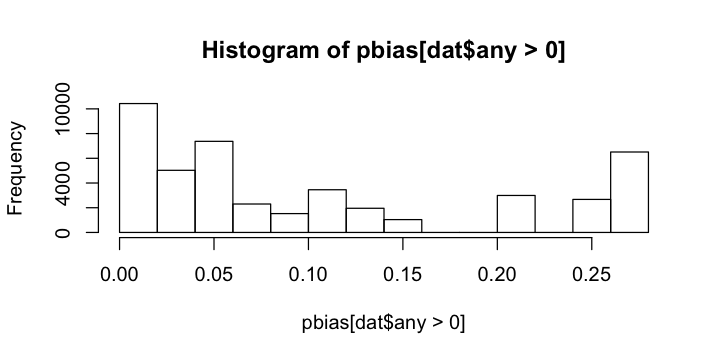

In [90]:
dat <- read.table("cancer_bkpts/icgc/brca_realcnts.txt", header=TRUE)
probs <- apply(dat[,6:9], 2, sum)
probs <- probs/sum(probs)
x <- apply(dat[,6:9], 1, dmultinom, prob=probs)
pbias <- x 
hist(pbias[dat$any > 0])


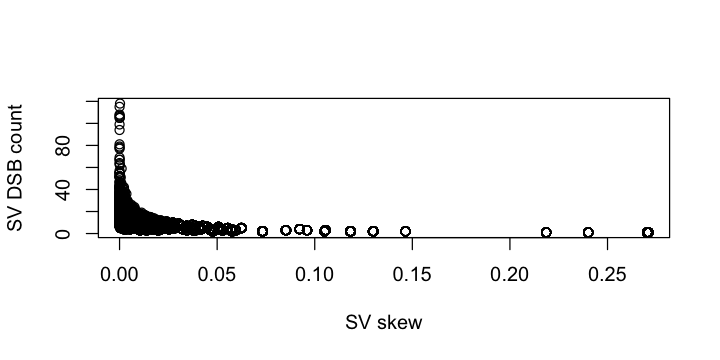

In [89]:
plot(pbias[dat$any>0], dat$any[dat$any > 0], xlab="SV skew", ylab="SV DSB count")

Warning message in ks.test(mydf$dat, dfnull$dat):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat):
“p-value will be approximate in the presence of ties”Warning message:
“Removed 246 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 273 rows containing non-finite values (stat_boxplot).”

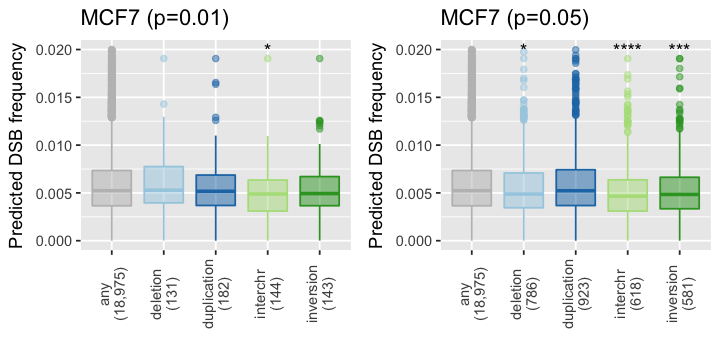

In [82]:
moddat <- read.table("MCF7_BICRO63/results_Mcf7_mNhek6/RM181921/predicted.txt", header=TRUE)
xi <- pbias <= 0.05 & dat$any > 0
mynull=5
mytypes=c("deletion", "duplication", "interchr", "inversion")
myc = c("grey", brewer.pal(4, "Paired"))

x <- make_tissue_type_boxdata(moddat$predicted[xi], pcf=0.01, types=mytypes, cntdat=dat[xi,], nulli=5)
pbox1 <- make_tissue_type_boxplots(x[[1]], x[[2]], mycols=myc, xl=0.02) + ggtitle("MCF7 (p=0.01)")

x <- make_tissue_type_boxdata(moddat$predicted[xi], pcf=0.05, types=mytypes, cntdat=dat[xi,], nulli=5)
pbox2 <- make_tissue_type_boxplots(x[[1]], x[[2]], mycols=myc, xl=0.02) + ggtitle("MCF7 (p=0.05)")

options(repr.plot.width=6, repr.plot.height=3)
grid.arrange(pbox1, pbox2, ncol=2)

## No skew

Warning message in ks.test(mydf$dat, dfnull$dat):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat):
“p-value will be approximate in the presence of ties”Warning message in ks.test(mydf$dat, dfnull$dat):
“p-value will be approximate in the presence of ties”Warning message:
“Removed 596 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 596 rows containing non-finite values (stat_boxplot).”

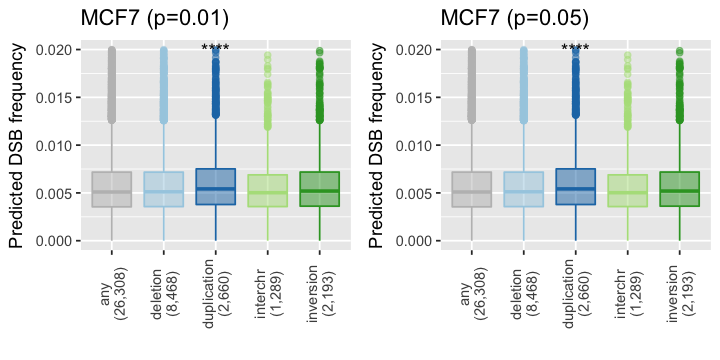

In [91]:
moddat <- read.table("MCF7_BICRO63/results_Mcf7_mNhek6/RM181921/predicted.txt", header=TRUE)
xi <- pbias > 0.05 & dat$any > 0
mynull=5
mytypes=c("deletion", "duplication", "interchr", "inversion")
myc = c("grey", brewer.pal(4, "Paired"))

x <- make_tissue_type_boxdata(moddat$predicted[xi], pcf=0.01, types=mytypes, cntdat=dat[xi,], nulli=5)
pbox1 <- make_tissue_type_boxplots(x[[1]], x[[2]], mycols=myc, xl=0.02) + ggtitle("MCF7 (p=0.01)")

x <- make_tissue_type_boxdata(moddat$predicted[xi], pcf=0.05, types=mytypes, cntdat=dat[xi,], nulli=5)
pbox2 <- make_tissue_type_boxplots(x[[1]], x[[2]], mycols=myc, xl=0.02) + ggtitle("MCF7 (p=0.05)")

options(repr.plot.width=6, repr.plot.height=3)
grid.arrange(pbox1, pbox2, ncol=2)